# Objectives

## 1. Bike Demand Prediction

-> At a given day of the week, location, and weather condition, how many rides are expected to start in a given region?

-> Purpose: Helps the company rebalance bikes so stations don’t run empty or overcrowded.

-> Business Value: This helps CoGo make sure bikes are distributed to meet demand, therefore maximinizing usage and revenue.

-> ML Requirement: While an average could be taken, it will not be able to capture the interactions or patterns explained by our feature variables as well as an ML model will, especially with the suspicion of non-linear relationships present. Additionally, building a model allows us to generalize previous results (years) to get a better estimate on future results (years) which is done through our train-test split being training on 2022 & 2023 and testing on 2024. Value insights into the strength and relationship of predictors on our response variable (# of rides) will also help the business determine allocation for marketing or potentially making the bikes more weather friendly as an example if weather has a strong negative relationship.

-> Best model: Random Forest Regressor

------

## 2. Trip Duration Prediction

-> Based on the start region, day of the week, and rider type (member/casual), how long is the trip likely last?

-> Purpose: Helps understand ride habits and can improve pricing models or customer experience.

-> Business Value: This helps CoGo proactively account for possible restock needed in a given region, and potentially maintenance demands since long rides likely put more strain.

-> ML Requirement: By using ML to model the expected ride duration, this allows the company to get ahead of maintanence impacts, which would be effectivly masked/ignored by simple summary statistics. This is another instance where ML has a large amount of power to capture nonlinear relationships/interactions using a large variety of inputs/features.

-> Best model: Requires significant tuning/modification before delivery. All model versions (multivariate regression, KNN, RF) are comporable and not explaining a significant amount of variation in the target variable, have large error, and trends/patterns in residuals.

-------

## 3. Rider Behavior Segmentation

-> Can we identify if a rider is a member or not based on when, where, and how they ride?

-> Purpose: Helps the company design better promotions and marketing (e.g., convert casual riders into members).

-> Business Value: This helps CoGo market to lesiure riders to be interested in a membership, stabilizing long term demand and competitve edge.

-> ML Requirement: In an effort for the company to target/personalize the bike ride experience, being able to model behavior/enviornmental impacts on the probability that a ride was taken by a member allows the company to understand behavior differences and potential areas to recruit new members, moreso than a standard statistic that 75% (example) of riders are members on day of the week. While the groups could be summarize, this would come at the sacrifice of being able to identify other areas to market/profit. Especially when transpotation (bikes, scooters, etc.) in downtown Columbus is a competitive market. More members means more market share, which means stable and long lasting demand compared to more leisure riders only. Additionally identify potential advertisement areas to convert non-members to members.

-> Best model: Logistic Regression

Data Assumptions:
- Date of ride comes from ride start
- Rides of duration > 1 day (1,440 mins) are data collection errors and excluded
- Rides with duration < 0 mins are data collection errors and excluded
- No other major changes to CoGo operations (pricing structure, bike availability, accessibility) impacted demand

-----
Some Modeling Assumptions:
- Multivariate
   * Input and output variables have a linear relationship
   * Residuals are independent
   * Mean(residuals) = 0 and var(residuals) = constant value
   * Residuals are appx. normally distributed
   * Little/no multicolinearity
- Logistic
   * Underlying linear relationship
   * Independent observarions
   * Sensitive to feature scaling
   * Little/no multicolinearity
- KNN
   * Sensitive to feature scaling
   * Non-parametric (no underlying requirement for linear vs non-linear relationship or distribution)
   * Euclidean distance is used
   * Similar data points (close) should have similar value (regression or classification)
- Decision Tree (DT)
   * Non-parametric (no underlying requirement for linear vs non-linear relationship or distribution)
   * loose assumption of independence in input features
- Tree Ensemble / Random Forest (RF)
   * Non-parametric (no underlying requirement for linear vs non-linear relationship or distribution)
   * low correlation between trees


Import Required Functions

In [ ]:
# Basic tools
import pandas as pd   # For working with data tables (dataframes)
import numpy as np    # For math, arrays, and numerical operations
import os
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt   # For plotting graphs
import seaborn as sns             # For pretty plots and charts

# Machine Learning (Scikit-learn), prep
from sklearn.preprocessing import StandardScaler # scaling when necessary for model
from sklearn.decomposition import PCA # feature analysis

# Machine Learning (Scikit-learn), modeling
from sklearn.linear_model import LinearRegression, LogisticRegression # Regression model
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # DT
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # RF
from sklearn.model_selection import cross_val_score # infreq use due to temporal split

# Machine Learning (Scikit-learn), evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay  # classification performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error # regression performance

# Specific cases
from geopy.distance import geodesic # distance, geopy used at TA's recommendation

# Import Data

## **Data Ingest**

In [ ]:
# Load the uploaded CSV files
bike_df = pd.read_csv("Cbus_Bike_Data_2022_2024.csv", low_memory=False) # low memory boolean avoids dtype warnings
weather_df = pd.read_csv("NOAA_Columbus_2018_2025.csv")

print('🚲 Bike Data Preview:\n',bike_df.head())

🚲 Bike Data Preview:
    Unnamed: 0           ride_id  rideable_type           started_at  \
0           1  864F163B1151C5DF   classic_bike  2022-01-20 17:57:24   
1           2  13BB5ECDAB30A747   classic_bike  2022-01-28 18:49:25   
2           3  99A68BC494138ACE   classic_bike  2022-01-27 19:05:01   
3           4  84618D3D8240B379  electric_bike  2022-01-05 12:52:39   
4           5  C2ABF3F51B578557  electric_bike  2022-01-17 16:14:24   

              ended_at      start_station_name start_station_id  \
0  2022-01-20 17:59:32      Front St & Beck St                3   
1  2022-01-28 18:56:22   Scioto Audubon Center                4   
2  2022-01-27 19:11:55   Scioto Audubon Center                4   
3  2022-01-05 13:38:37       Bicentennial Park                1   
4  2022-01-17 16:22:09  Neil Ave & Buttles Ave               22   

         end_station_name end_station_id  start_lat  start_lng    end_lat  \
0  Bank St & Frankfort St              8  39.950149 -83.000243  39.9465

# **Prepare Secondary Dataset (Weather Data)**

In [ ]:
## Emma
## Weather data EDA and prep (secondary dataset)
print("\n🌦️ Raw Weather data shape: ", weather_df.shape)
print("\n🌦️ Raw Weather data info:\n", )
print(weather_df.info())

valid_station = weather_df[weather_df['TAVG'].notna()]['STATION'].unique().ravel()[0]
print("\n\n🌦️ Weather Station with valid temperature data: ", valid_station)

# Only keep station, temperature, date, and precip fields
weather_df_subset = weather_df[['STATION','DATE','TAVG','TMIN','TMAX','PRCP','SNOW']]
# only one station has relevant temperature data
weather_df_subset = weather_df_subset[weather_df_subset['STATION'] == valid_station]

# Print updated dataset statistics
print("\n\n🌦️ Valid Station Weather data shape, fields of interest only: ",weather_df_subset.shape)
print("\n🌦️ Updated data describe:\n", weather_df_subset.describe())
print("\n🌦️ Date Format:\n",weather_df_subset['DATE'].head())

# View date field format for filtering and join
weather_df_subset['DATE'].head(3)
# Weather date field is YYYY-MM-DD, remove any whitespace before filtering and join
weather_df_subset['DATE'] = weather_df_subset['DATE'].astype(str).str.strip()
weather_df_subset_daterange = weather_df_subset[weather_df_subset['DATE'].between('2022-01-01', '2024-12-31')]

print("\n🌦️ NA counts on timespan of interest:\n",weather_df_subset_daterange.isna().sum())
if(weather_df_subset_daterange.isna().sum().max() > 0):
  print('❗NAs detected in required fields, please remedy before proceeding❗')

# note if cleaning is required, fences set by intuition on Ohio weather
if((weather_df_subset_daterange[['TAVG','TMIN','TMAX']].max().max()) < 110) & (weather_df_subset_daterange[['TAVG','TMIN','TMAX']].min().min() >= -20):
  print("\n🌦️No weather data cleaning is required, temperatures fall in reasonable range for Ohio")
else:
  print("\n❗Weather data needs cleaning before continuting analysis❗")
  print(weather_df_subset[['TAVG','TMIN','TMAX']].max().max())
  print(weather_df_subset[['TAVG','TMIN','TMAX']].min().min())

weather_df_final = weather_df_subset_daterange.copy()

# define a boolean for rain/precipitation, success (1) = precip
weather_df_final['precip_bool'] = (weather_df_final['PRCP'] > 0).astype(int)
# define a boolean for snow, success (1) = snow
weather_df_final['snow_bool'] = (weather_df_final['SNOW'] > 0).astype(int)


🌦️ Raw Weather data shape:  (83014, 29)

🌦️ Raw Weather data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83014 entries, 0 to 83013
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  83014 non-null  object 
 1   NAME     83014 non-null  object 
 2   DATE     83014 non-null  object 
 3   AWND     5578 non-null   float64
 4   DAPR     1328 non-null   float64
 5   MDPR     1314 non-null   float64
 6   PGTM     397 non-null    float64
 7   PRCP     81655 non-null  float64
 8   SNOW     44839 non-null  float64
 9   SNWD     17466 non-null  float64
 10  TAVG     2793 non-null   float64
 11  TMAX     11151 non-null  float64
 12  TMIN     11150 non-null  float64
 13  TOBS     5551 non-null   float64
 14  WDF2     5580 non-null   float64
 15  WDF5     5581 non-null   float64
 16  WESD     3102 non-null   float64
 17  WESF     4270 non-null   float64
 18  WSF2     5581 non-null   float64
 19  WSF5     5581 non-n

# **Data Wrangling / Exploratory Data Analysis (EDA)**

1.   Discovery - Data types, Null Counts, Summary Stats, Identify Outliers
2.   Structuring - Standardize as needed
3.   Cleaning - Remove/replace NA & outlier data
4.   Enriching - Derive new features as needed
5.   Validating - Check for data consistency


## Discovery

In [ ]:
## Shilp
## Discovery
print("\n🚲 Bike data info:\n")
print(bike_df.info())

print("\n🚲 Bike data describe:\n", bike_df.describe())

print("\n🚲 Bike data describe:\n", bike_df.isna().sum())

## outlier detection done in cleaning for derived columns


🚲 Bike data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161458 entries, 0 to 161457
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          161458 non-null  int64  
 1   ride_id             161458 non-null  object 
 2   rideable_type       161458 non-null  object 
 3   started_at          161458 non-null  object 
 4   ended_at            161458 non-null  object 
 5   start_station_name  146531 non-null  object 
 6   start_station_id    146467 non-null  object 
 7   end_station_name    138727 non-null  object 
 8   end_station_id      138664 non-null  object 
 9   start_lat           161458 non-null  float64
 10  start_lng           161457 non-null  float64
 11  end_lat             161099 non-null  float64
 12  end_lng             161099 non-null  float64
 13  member_casual       161457 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 17.2+ MB
None



## Structuring

In [ ]:
## Adrian
## Structuring

counts = bike_df.value_counts()
print(counts)

Unnamed: 0  ride_id           rideable_type  started_at               ended_at                 start_station_name           start_station_id  end_station_name                  end_station_id  start_lat  start_lng   end_lat    end_lng     member_casual
161457      2D3171CBB59889ED  electric_bike  2024-08-17 21:55:58.093  2024-08-17 22:37:56.659  Schiller Park - Stewart Ave  6                 Schiller Park - Stewart Ave       6               39.941996  -82.995018  39.941996  -82.995018  member           1
1           864F163B1151C5DF  classic_bike   2022-01-20 17:57:24      2022-01-20 17:59:32      Front St & Beck St           3                 Bank St & Frankfort St            8               39.950149  -83.000243  39.946596  -83.000349  member           1
2           13BB5ECDAB30A747  classic_bike   2022-01-28 18:49:25      2022-01-28 18:56:22      Scioto Audubon Center        4                 Bank St & Frankfort St            8               39.945884  -83.009046  39.946596  -83.0003

In [ ]:
# Adrian
#check coordinate ranges are all coded as numeric and valid coordinates
# Coordinates for Columbus, OH is 39.9625° N, 83.0032° W (corresponding to -83)
print(bike_df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].describe())

           start_lat      start_lng        end_lat        end_lng
count  161458.000000  161457.000000  161099.000000  161099.000000
mean       39.973845     -83.002863      39.973869     -83.002831
std         0.021891       0.019676       0.022094       0.020149
min        39.000000     -83.110000      39.870000     -83.240000
25%        39.959074     -83.010000      39.958965     -83.011088
50%        39.968171     -83.003518      39.968528     -83.003507
75%        39.985777     -82.998107      39.985822     -82.998107
max        40.090000     -82.870000      40.290000     -82.820000


In [ ]:
# Emma
# Standardize timestamp columns
print("Raw start max: ",bike_df['started_at'].max())
print("Raw start min: ",bike_df['started_at'].min())
print("Raw end max: ",bike_df['ended_at'].max())
print("Raw end min: ",bike_df['ended_at'].min())

# drop the milliseconds for consistency to the YYYY-MM-DD HH:MM:SS format
bike_df['started_at'] = bike_df['started_at'].astype(str).str.split('.').str[0]
bike_df['ended_at'] = bike_df['ended_at'].astype(str).str.split('.').str[0]

# verify max is different and min is untouched
print("\nClean start max: ",bike_df['started_at'].max())
print("Clean start min: ",bike_df['started_at'].min())
print("Clean end max: ",bike_df['ended_at'].max())
print("Clean end min: ",bike_df['ended_at'].min())

Raw start max:  2024-08-31 23:44:19.219
Raw start min:  2022-01-01 00:38:32
Raw end max:  2024-08-31 23:57:49.950
Raw end min:  2022-01-01 00:54:20

Clean start max:  2024-08-31 23:44:19
Clean start min:  2022-01-01 00:38:32
Clean end max:  2024-08-31 23:57:49
Clean end min:  2022-01-01 00:54:20


In [ ]:
# Adrian
# Standardize Stations IDs
bike_df['start_station_id'] = bike_df['start_station_id'].astype(str)
bike_df['end_station_id'] = bike_df['end_station_id'].astype(str)

#Standardize Case and Naming
bike_df['start_station_name'] = bike_df['start_station_name'].astype(str)
bike_df['end_station_name'] = bike_df['end_station_name'].astype(str)
bike_df['start_station_name'] = bike_df['start_station_name'].str.title()
bike_df['end_station_name'] = bike_df['end_station_name'].str.title()

print(bike_df['start_station_name'].unique())

['Front St & Beck St' 'Scioto Audubon Center' 'Bicentennial Park'
 'Neil Ave & Buttles Ave' 'Dorrian Commons - Mound St'
 'Library - Whetstone Branch' 'High St & Broad St' 'High St & Hudson St'
 'Front St & Town St' 'High St & 11Th Ave' 'High St & 2Nd Ave'
 'Columbus College Of Art & Design' 'Jaeger St & Whittier St'
 'Wellesley Dr & Lane Ave' 'Nan' 'North Market' 'Lucas St & Town St'
 'Grandview Ave & 3Rd Ave' 'Columbus Commons - Rich St'
 'Northwest Blvd & 3Rd Ave' 'Go Fitness Iv (Italian Village) 4Th/1St'
 'Lane Ave At Olentangy Trail' 'Taylor Ave & Long St'
 'Parsons Ave & Oak St' 'Neil Ave & King Ave'
 'Mallway Park At Arlington Ave' 'Summit St & 17Th Ave' 'Livingston Park'
 'North Bank Park' 'High St & Lane Ave' 'King Arts Complex'
 'Library - Main Branch' 'Bank St & Frankfort St'
 'Schiller Park - Stewart Ave' 'Cosi' 'City Hall' 'Michigan Ave & 3Rd Ave'
 'Nationwide Arena - Front St' 'High St & King Ave' 'Neil Ave & 10Th Ave'
 'Summit St & Hudson St' 'Thompson Park At Hunter Ave

## Cleaning

In [ ]:
## Shilp
## Cleaning
# iqr = (quantile(0.75) - quantile(0.25))
# quantile(0.25) - 1.5*iqr
# quantile(0.75) + 1.5*iqr

# Optional nicer interactive table in Colab
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except Exception:
    pass

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 30)

In [ ]:
# Shilp
bike = bike_df.copy()
print("bike shape:", bike.shape)
print("\nColumns:\n", bike.columns.tolist())
bike.head(5)

bike shape: (161458, 14)

Columns:
 ['Unnamed: 0', 'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1,864F163B1151C5DF,classic_bike,2022-01-20 17:57:24,2022-01-20 17:59:32,Front St & Beck St,3,Bank St & Frankfort St,8,39.950149,-83.000243,39.946596,-83.000349,member
1,2,13BB5ECDAB30A747,classic_bike,2022-01-28 18:49:25,2022-01-28 18:56:22,Scioto Audubon Center,4,Bank St & Frankfort St,8,39.945884,-83.009046,39.946596,-83.000349,member
2,3,99A68BC494138ACE,classic_bike,2022-01-27 19:05:01,2022-01-27 19:11:55,Scioto Audubon Center,4,Bank St & Frankfort St,8,39.945884,-83.009046,39.946596,-83.000349,member
3,4,84618D3D8240B379,electric_bike,2022-01-05 12:52:39,2022-01-05 13:38:37,Bicentennial Park,1,Scioto Audubon Center,4,39.955956,-83.003256,39.945884,-83.009046,casual
4,5,C2ABF3F51B578557,electric_bike,2022-01-17 16:14:24,2022-01-17 16:22:09,Neil Ave & Buttles Ave,22,City Hall,2,39.977384,-83.011621,39.962989,-83.004253,member


In [ ]:
# Shilp
# initial checks
print("Missing counts (top 20):")
print(bike.isna().sum().sort_values().head(20))

# Duplicate ride_id?
if 'ride_id' in bike.columns:
    dup_count = bike['ride_id'].duplicated().sum()
    print("\nDuplicate ride_id count:", dup_count)

# preview types
print("\nValue counts for some useful cols:")
for c in ['rideable_type', 'member_casual']:
    if c in bike.columns:
        print("\n", c, "->")
        print(bike[c].value_counts(dropna=False).head(10))

Missing counts (top 20):
Unnamed: 0              0
ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name        0
end_station_id          0
start_lat               0
start_lng               1
member_casual           1
end_lat               359
end_lng               359
dtype: int64

Duplicate ride_id count: 1

Value counts for some useful cols:

 rideable_type ->
rideable_type
electric_bike    86335
classic_bike     74712
docked_bike        411
Name: count, dtype: int64

 member_casual ->
member_casual
member    83460
casual    77997
NaN           1
Name: count, dtype: int64


In [ ]:
# Shilp
print(bike.tail())

        Unnamed: 0           ride_id  rideable_type           started_at  \
161453      161454  1453987F0212256D   classic_bike  2024-08-07 13:06:29   
161454      161455  50E873ECB04A3ED9  electric_bike  2024-08-09 17:31:32   
161455      161456  ABB424BC67E71E4F  electric_bike  2024-08-07 22:05:16   
161456      161457  2D3171CBB59889ED  electric_bike  2024-08-17 21:55:58   
161457      161458  87D4F855C5F414E7   classic_bike  2024-08-08 17:17:56   

                   ended_at           start_station_name start_station_id  \
161453  2024-08-07 13:10:37           High St & King Ave               50   
161454  2024-08-09 18:15:42  Schiller Park - Stewart Ave                6   
161455  2024-08-07 22:50:17  Schiller Park - Stewart Ave                6   
161456  2024-08-17 22:37:56  Schiller Park - Stewart Ave                6   
161457  2024-08-08 17:21:13           High St & 11Th Ave               51   

                   end_station_name end_station_id  start_lat  start_lng  \
1614

In [ ]:
# Shilp
#parse datetimes and create time features, already structured for alignment
bike['started_at'] = pd.to_datetime(bike['started_at'], errors='coerce')
bike['ended_at']   = pd.to_datetime(bike['ended_at'], errors='coerce')

# show rows where parsing failed (if any)
print("started_at NaT:", bike['started_at'].isna().sum())
print("ended_at NaT:", bike['ended_at'].isna().sum())

# duration in minutes
bike['duration_min'] = (bike['ended_at'] - bike['started_at']).dt.total_seconds() / 60.0

# quick stats
print("\nDuration stats (min):")
print(bike['duration_min'].describe())

started_at NaT: 0
ended_at NaT: 0

Duration stats (min):
count    161458.000000
mean         26.591414
std         162.023271
min          -3.433333
25%           7.133333
50%          12.800000
75%          25.283333
max       43433.500000
Name: duration_min, dtype: float64


In [ ]:
# Shilp
# ride cannot take negative time, no time travel possible
bad_dur = bike[bike['duration_min'] <= 0]
print("Rows with duration <= 0:", len(bad_dur))
# show a few to inspect
bad_dur.head(5)

# ride cannot last more than 1 day straight, per assumption
bad_dur_long = bike[bike['duration_min'] > 1440]
print("Rows with duration > 1,440 (60*24):", len(bad_dur_long))
# show a few to inspect
bad_dur_long.head(5)

# Decision: drop rows with missing started/ended, or duration <= 0 or duration > 1440
bike = bike.dropna(subset=['started_at', 'ended_at'])            # no valid times
bike = bike[(bike['duration_min'] > 0) & (bike['duration_min'] < 1440)]

# If you prefer to keep very short trips (e.g., < 0.5 min), adjust above as needed
print("After dropping bad durations shape:", bike.shape)

Rows with duration <= 0: 28
Rows with duration > 1,440 (60*24): 353
After dropping bad durations shape: (161077, 15)


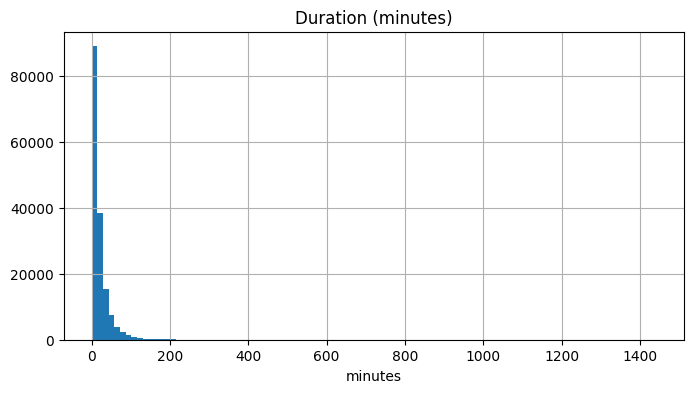

,duration_min
count,161077.000000
mean,22.588916
std,46.034952
min,0.016667
25%,7.116667
50%,12.766667
75%,25.150000
max,1439.916667


In [ ]:
# Shilp
# explore duration filtered for bounds, no outlier cleaning yet
import matplotlib.pyplot as plt

# Distribution of durations (capped)
plt.figure(figsize=(8,4))
bike['duration_min'].hist(bins=100)
plt.title("Duration (minutes)")
plt.xlabel("minutes")
plt.show()

bike[['duration_min']].describe()

In [ ]:
# Shilp
# keep only lat/lng for Columbus metro area, which is CoGo area of operation
for col in ['start_lat', 'start_lng', 'end_lat', 'end_lng']:
    if col in bike.columns:
        print(col, "missing:", bike[col].isna().sum())

# Remove rows with totally missing start coordinates if required
if 'start_lat' in bike.columns and 'start_lng' in bike.columns:
    bike = bike.dropna(subset=['start_lat', 'start_lng'])

# Optionally filter to reasonable bounding box for Columbus (example)
# (39.5 to 40.2 latitude, -84.0 to -82.5 longitude) - tweak if needed
if 'start_lat' in bike.columns and 'start_lng' in bike.columns:
    lat_ok = bike['start_lat'].between(39.5, 40.2)
    lng_ok = bike['start_lng'].between(-84.0, -82.5)
    before = bike.shape[0]
    bike = bike[lat_ok & lng_ok]
    print("Filtered by bounding box. Rows removed:", before - bike.shape[0])


start_lat missing: 0
start_lng missing: 1
end_lat missing: 11
end_lng missing: 11
Filtered by bounding box. Rows removed: 0


In [ ]:
# Shilp
#  IQR outlier detection for duration_min
col = 'duration_min'
Q1 = bike[col].quantile(0.25)
Q3 = bike[col].quantile(0.75)
IQR = Q3 - Q1
k = 1.5
lower = Q1 - k * IQR
upper = Q3 + k * IQR
print(f"Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
print(f"Lower bound = {lower:.2f}, Upper bound = {upper:.2f}")

# Mark outliers
bike['duration_outlier_iqr'] = ~bike[col].between(lower, upper)

print("Outlier count (IQR):", bike['duration_outlier_iqr'].sum())
bike[bike['duration_outlier_iqr']].sample(5)   # view some outlier examples


Q1=7.12, Q3=25.15, IQR=18.03
Lower bound = -19.93, Upper bound = 52.20
Outlier count (IQR): 13036


,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_min,duration_outlier_iqr
28810,28811,11614FA8C7D9F4A9,classic_bike,2022-08-04 11:53:18,2022-08-04 13:13:20,3Rd St & Sycamore St,10,3Rd St & Sycamore St,10,39.949433,-82.995355,39.949433,-82.995355,casual,80.033333,True
43977,43978,7D926234F96DE5CB,classic_bike,2022-10-22 20:48:38,2022-10-23 03:33:16,Sensenbrenner Park,16,Sensenbrenner Park,16,39.968528,-83.001614,39.968528,-83.001614,casual,404.633333,True
141813,141814,F0FBC8797111A8E2,electric_bike,2024-06-01 23:10:56,2024-06-02 00:39:53,North Market,20,Bicentennial Park,1,39.973377,-83.004664,39.955924,-83.003221,casual,88.950000,True
4372,4373,51C13E9873ADFF77,classic_bike,2022-04-23 12:16:31,2022-04-23 13:21:18,City Hall,2,City Hall,2,39.962989,-83.004253,39.962989,-83.004253,casual,64.783333,True
145987,145988,ED1B426AD9ACFE0E,electric_bike,2024-06-01 20:16:35,2024-06-01 21:13:47,Bexley City Hall At Main St,71,Franklin Park At Fairwood Ave,91,39.957362,-82.940238,39.963267,-82.953245,casual,57.200000,True


In [ ]:
# Shilp
# Cell 9: two possible strategies. Choose ONE.
# capping large values was chosen to best capture the impact
# of high duration rides, as that is a key column in analysis

# Option A: drop IQR outliers (aggressive)
bike_dropped = bike[~bike['duration_outlier_iqr']].copy()
print("Shape after dropping outliers:", bike_dropped.shape)

# Option B: cap (winsorize) durations at lower/upper bound (less destructive)
bike_winsor = bike.copy()
bike_winsor['duration_min_capped'] = bike_winsor['duration_min'].clip(lower, upper)
print("Shape if we cap instead of dropping:", bike_winsor.shape)

# Choose which dataset you want to keep for modeling:
# bike_clean = bike_dropped   # if you decide to drop
# bike_clean = bike_winsor    # if you decide to cap
# For now, keep the capped version (safer)
bike_clean = bike_winsor


Shape after dropping outliers: (148040, 16)
Shape if we cap instead of dropping: (161076, 17)


In [ ]:
# Shilp
# final column selection and save
keep_cols = [
    'ride_id','rideable_type','member_casual',
    'started_at','ended_at',
    'duration_min','duration_min_capped',
    'start_station_id','start_station_name','start_lat','start_lng',
    'end_station_id','end_station_name','end_lat','end_lng'
]
# keep only existing columns
keep_cols = [c for c in keep_cols if c in bike_clean.columns]

final = bike_clean[keep_cols].copy()
print("Final shape to save:", final.shape)
final.head(3)

# Save locally in Colab
final.to_csv("bike_cleaned.csv", index=False)
print("Saved bike_cleaned.csv")

# Optional: save to Google Drive (uncomment to use)
# from google.colab import drive
# drive.mount('/content/drive')
# final.to_csv("/content/drive/MyDrive/bike_cleaned.csv", index=False)
# print("Saved to Google Drive at /content/drive/MyDrive/bike_cleaned.csv")

Final shape to save: (161076, 15)
Saved bike_cleaned.csv


In [ ]:
# Shilp
# view cleaned duration summary stats
print(final[['duration_min_capped']].describe())

       duration_min_capped
count        161076.000000
mean             18.214970
std              14.941846
min               0.016667
25%               7.116667
50%              12.766667
75%              25.150000
max              52.200000


Top 10 start stations:
 start_station_name
Nan                      14926
Bicentennial Park         6926
High St & Warren          4277
Scioto Audubon Center     4100
North Bank Park           3866
High St & Broad St        3854
Neil Ave & 10Th Ave       3208
High St & 2Nd Ave         3179
Yard St & Burr Ave        2998
Parsons Ave & Oak St      2875
Name: count, dtype: int64


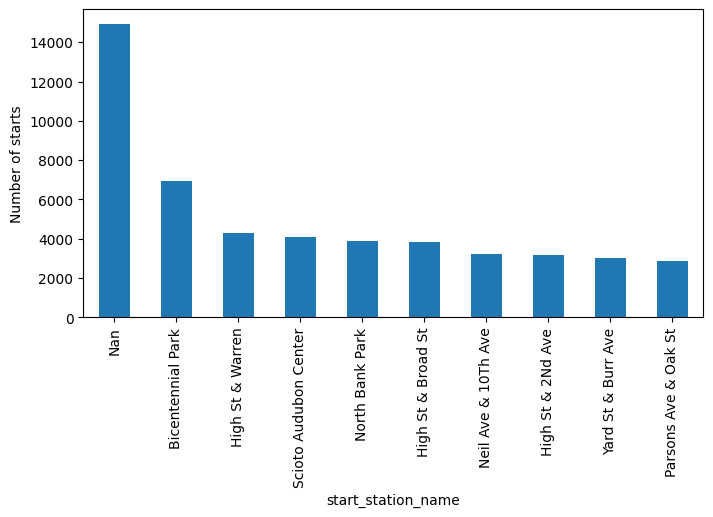

In [ ]:
# Shilp
# validated histogram to see range after cleaning
# Distribution of durations (capped)
# plt.figure(figsize=(8,4))
# final['duration_min_capped'].hist(bins=80)
# plt.title("Duration (minutes) - capped")
# plt.xlabel("minutes")
# plt.show()

# Top 10 busiest start stations
if 'start_station_name' in final.columns:
    top = final['start_station_name'].value_counts().nlargest(10)
    print("Top 10 start stations:\n", top)
    top.plot(kind='bar', figsize=(8,4))
    plt.ylabel("Number of starts")
    plt.show()


## Enriching

In [ ]:
# Emma
## Enriching
# Ride duration is calculated in cleaning since it is a desired output,
# and therefore outlier detection was explored

# Calculating roundtrip boolean, 1 (success) = RT
final['round_trip_bool'] = (final['start_station_id'] == final['end_station_id']).astype(int)

# drop index for row number referencing
final = final.reset_index(drop=True)

# Calculating ride distance (will be 0 for round trips), exe is ~30s
distance_m = []
for i in range(len(final)):
  lat_start = final.loc[i,'start_lat']
  lng_start = final.loc[i,'start_lng']
  lat_end = final.loc[i,'end_lat']
  lng_end = final.loc[i,'end_lng']
  rt = final.loc[i,'round_trip_bool']

  # if it is a round trip, distance is 0
  if rt == 1:
    d = 0
    # if it is not a roundtrip, but we have NAs, return NaN
  elif ((any(pd.isna([lat_start, lng_start, lat_end, lng_end])))):
    d = np.nan
  else:
    # if it is not a roundtrip, and no NAs, calculate distance in miles
    d = geodesic((lat_start, lng_start), (lat_end, lng_end)).miles
  # save the distance calculated
  distance_m.append(d)

# add calculated distances to dataframe
final['distance_traveled_miles'] = distance_m

In [ ]:
# Emma
final['distance_traveled_miles'].describe()
# on average the distance between start and end of the ride is 1 mile directly
# actual distance traveled may be more for routing or circles

,distance_traveled_miles
count,161066.000000
mean,1.006520
std,0.976751
min,0.000000
25%,0.285122
50%,0.809052
75%,1.412324
max,23.178044


In [ ]:
# Emma
# opt refresh from save for enriching data changes
#final = final_save.copy()
# using trip start (in line with assumption) determine day of the week for the ride
# extract date, ymd
final['date']    = final['started_at'].dt.date
# extract year, may be used for split modeling later
final['year']    = final['started_at'].dt.year
# extract month
final['month']   = final['started_at'].dt.month
# extract day of the month
final['day']     = final['started_at'].dt.day
# extract hour
final['hour']    = final['started_at'].dt.hour
# extract dat of week, string and numeric
final['day_of_week'] = final['started_at'].dt.day_name()
final['weekday'] = final['started_at'].dt.weekday    # 0=Mon

# retain string column, useful for graphing or grouping by day
final['day_of_week_str'] = final['day_of_week']
# binary for 1 on Sat/Sun and 0 otherwise
final['weekend'] = final['day_of_week_str'].isin(['Saturday', 'Sunday']).astype(int)
# create dummy columns for the day of the week
final = pd.get_dummies(final, columns=['day_of_week_str'], dtype=int, prefix = 'day')

# create column for season (winter, spring, summer, fall)
# this is likely not the most efficient solution, but it was the only one accessible
# define season (using 22nd as changepoint) and then create dummy variables
for i in range(len(final)):
  # assign full months (no season changepoints)
  if final.loc[i,'month'] in [1,2]:
    final.loc[i,'season'] = 'winter'
  elif final.loc[i,'month'] in [4,5]:
    final.loc[i,'season'] = 'spring'
  elif final.loc[i,'month'] in [7,8]:
    final.loc[i,'season'] = 'summer'
  elif final.loc[i,'month'] in [10,11]:
    final.loc[i,'season'] = 'fall'
  # assign winter->spring change, days 1-21 are winter, 22 and beyond spring
  elif final.loc[i,'month'] == 3:
    if final.loc[i,'day'] < 22:
      final.loc[i,'season'] = 'winter'
    else:
      final.loc[i,'season'] = 'spring'
    # assign spring->summer change, days 1-21 are spring, 22 and beyond summer
  elif final.loc[i,'month'] == 6:
    if final.loc[i,'day'] < 22:
      final.loc[i,'season'] = 'spring'
    else:
      final.loc[i,'season'] = 'summer'
    # assign summer->fall change, 1-21 summer, and 22 beyond fall
  elif final.loc[i,'month'] == 9:
    if final.loc[i,'day'] < 22:
      final.loc[i,'season'] = 'summer'
    else:
      final.loc[i,'season'] = 'fall'
    # assign fall->winter change, 1-21 fall, and 22 beyond winter
  elif final.loc[i,'month'] == 12:
    if final.loc[i,'day'] < 22:
      final.loc[i,'season'] = 'fall'
    else:
      final.loc[i,'season'] = 'winter'
else:
  final.loc[i,'season'] = float('nan')
# retain a copy of the season for further analysis, define copy before dummying
final['season_str'] = final['season']
final = pd.get_dummies(final, columns=['season_str'],
                       dtype=int,
                       prefix = 'season',
                       drop_first = True)
# view with updated columns
print(final.head())

            ride_id  rideable_type member_casual          started_at  \
0  864F163B1151C5DF   classic_bike        member 2022-01-20 17:57:24   
1  13BB5ECDAB30A747   classic_bike        member 2022-01-28 18:49:25   
2  99A68BC494138ACE   classic_bike        member 2022-01-27 19:05:01   
3  84618D3D8240B379  electric_bike        casual 2022-01-05 12:52:39   
4  C2ABF3F51B578557  electric_bike        member 2022-01-17 16:14:24   

             ended_at  duration_min  duration_min_capped start_station_id  \
0 2022-01-20 17:59:32      2.133333             2.133333                3   
1 2022-01-28 18:56:22      6.950000             6.950000                4   
2 2022-01-27 19:11:55      6.900000             6.900000                4   
3 2022-01-05 13:38:37     45.966667            45.966667                1   
4 2022-01-17 16:22:09      7.750000             7.750000               22   

       start_station_name  start_lat  start_lng end_station_id  \
0      Front St & Beck St  39.950149 -

In [ ]:
# Emma
# define regions of columbus, N E S W by relation to average (center lat/lng)
center_lat = np.mean(final['start_lat'])
center_lng = np.mean(final['start_lng'])

for i in range(len(final)):
  if final.loc[i,'start_lat'] >= center_lat and final.loc[i,'start_lng'] >= center_lng:
    final.loc[i,'region'] = 'NE'
  elif final.loc[i,'start_lat'] >= center_lat and final.loc[i,'start_lng'] < center_lng:
    final.loc[i,'region'] = 'NW'
  elif final.loc[i,'start_lat'] < center_lat and final.loc[i,'start_lng'] < center_lng:
    final.loc[i,'region'] = 'SW'
  elif final.loc[i,'start_lat'] < center_lat and final.loc[i,'start_lng'] >= center_lng:
    final.loc[i,'region'] = 'SE'
  else:
    pass

final['region_str'] = final['region']
# drop one category to avoid multicolinearity
final = pd.get_dummies(final, columns=['region_str'], dtype=int, prefix = 'region', drop_first=True)
print(final.columns)

Index(['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at',
       'duration_min', 'duration_min_capped', 'start_station_id',
       'start_station_name', 'start_lat', 'start_lng', 'end_station_id',
       'end_station_name', 'end_lat', 'end_lng', 'round_trip_bool',
       'distance_traveled_miles', 'date', 'year', 'month', 'day', 'hour',
       'day_of_week', 'weekday', 'weekend', 'day_Friday', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'season', 'season_spring', 'season_summer',
       'season_winter', 'region', 'region_NW', 'region_SE', 'region_SW'],
      dtype='object')


In [ ]:
# Emma
# dummy membership and rideable type
# membership only has 2 values, member is success
# rideables have 3 values, classic dummy vars
#print(final['member_casual'].unique())
final['member_dummy'] = (final['member_casual'] == 'member').astype(int)

final['rideable_type_str'] = final['rideable_type']
# drop first dummy var to avoid perfect multicolinearity
final = pd.get_dummies(final, columns=['rideable_type_str'], dtype=int, prefix = 'dummy', drop_first=True)

In [ ]:
# Emma
# Adding in temperature and preceipitation data from weather dataset for the date
final_joined = final.copy()

# trim bike data date to only YYYY-MM-DD to match weather data format
final_joined['date'] = final_joined['started_at'].dt.date
# convert to string to make sure types are equivalent for join key
final_joined['date'] = final_joined['date'].astype(str)

# left join to keep all bike data on bike date = weather DATE
final_joined = final_joined.merge(weather_df_final, left_on='date', right_on='DATE', how='left')
# check summary statistics
final_joined.describe()

,started_at,ended_at,duration_min,duration_min_capped,start_lat,start_lng,end_lat,end_lng,round_trip_bool,distance_traveled_miles,year,month,day,hour,weekday,weekend,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_spring,season_summer,season_winter,region_NW,region_SE,region_SW,member_dummy,dummy_docked_bike,dummy_electric_bike,TAVG,TMIN,TMAX,PRCP,SNOW,precip_bool,snow_bool
count,161076,161076,161076.000000,161076.000000,161076.000000,161076.000000,161066.000000,161066.000000,161076.000000,161066.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000,161076.000000
mean,2023-06-10 00:43:26.068917504,2023-06-10 01:06:01.411097856,22.589036,18.214970,39.973850,-83.002870,39.973869,-83.002830,0.214793,1.006520,2022.927630,6.651817,15.683528,14.818601,3.353020,0.376841,0.142156,0.114064,0.215606,0.161234,0.124115,0.119037,0.123786,0.332185,0.404654,0.101629,0.343229,0.371228,0.218034,0.517836,0.002458,0.535834,64.364275,54.034419,75.096737,0.080101,0.006760,0.277366,0.007853
min,2022-01-01 00:38:32,2022-01-01 00:54:20,0.016667,0.016667,39.890000,-83.110000,39.870000,-83.240000,0.000000,0.000000,2022.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-7.000000,16.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-09-17 19:25:23.500000,2022-09-17 19:49:45.500000,7.116667,7.116667,39.959074,-83.010000,39.958965,-83.011088,0.000000,0.285122,2022.000000,5.000000,8.000000,12.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,46.000000,68.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-07-02 18:31:43.500000,2023-07-02 19:00:52,12.766667,12.766667,39.968170,-83.003521,39.968528,-83.003507,0.000000,0.809052,2023.000000,7.000000,16.000000,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,68.000000,58.000000,79.000000,0.000000,0.000000,0.000000,0.000000
75%,2024-02-03 16:23:29.249999872,2024-02-03 17:06:15.249999872,25.150000,25.150000,39.985777,-82.998107,39.985822,-82.998107,0.000000,1.412324,2024.000000,8.000000,23.000000,18.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,74.000000,64.000000,85.000000,0.020000,0.000000,1.000000,0.000000
max,2024-08-31 23:44:19,2024-08-31 23:57:49,1439.916667,52.200000,40.090000,-82.870000,40.290000,-82.820000,1.000000,23.178044,2024.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,85.000000,77.000000,98.000000,3.700000,4.900000,1.000000,1.000000
std,NaN,NaN,46.035070,14.941846,0.021753,0.019669,0.022094,0.020149,0.410680,0.976751,0.766404,2.518267,8.868257,5.102916,1.989373,0.484596,0.349212,0.317890,0.411244,0.367748,0.329714,0.323833,0.329339,0.470998,0.490826,0.302161,0.474789,0.483135,0.412912,0.499683,0.049522,0.498716,13.311700,13.503125,13.813698,0.246943,0.126159,0.447700,0.088271


In [ ]:
# Emma
#OPT: print NA counts with new added cols
# final_joined.isna().sum()

## Validating

NA counts by column: 
 ride_id          0
rideable_type    0
member_casual    0
started_at       0
ended_at         0
                ..
TMAX             0
PRCP             0
SNOW             0
precip_bool      0
snow_bool        0
Length: 52, dtype: int64

Columns with NAs: 
 end_lat                    True
end_lng                    True
distance_traveled_miles    True
season                     True
dtype: bool

 ride_id                  object
rideable_type            object
member_casual            object
started_at       datetime64[ns]
ended_at         datetime64[ns]
                      ...      
TMAX                    float64
PRCP                    float64
SNOW                    float64
precip_bool               int64
snow_bool                 int64
Length: 52, dtype: object

 1


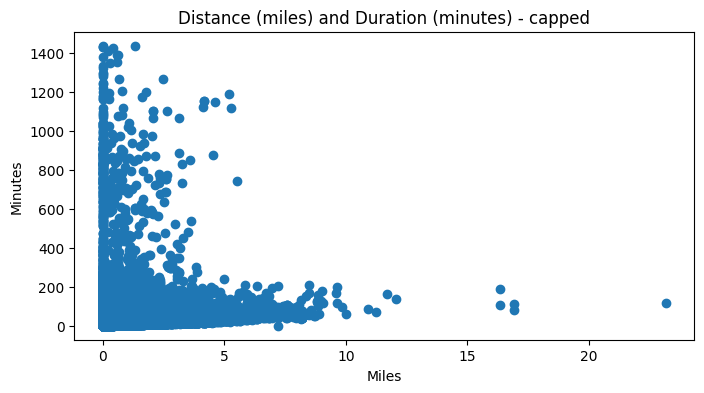

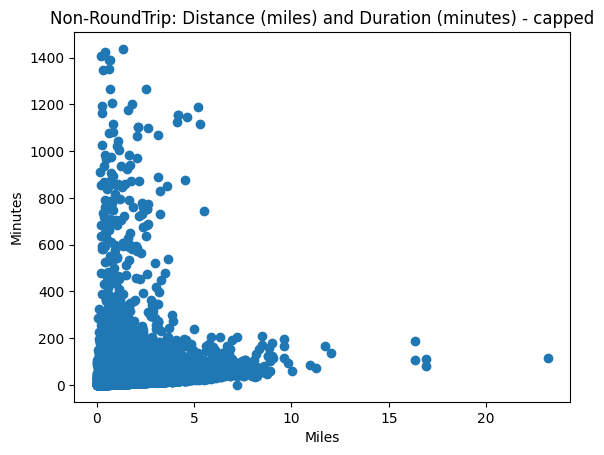

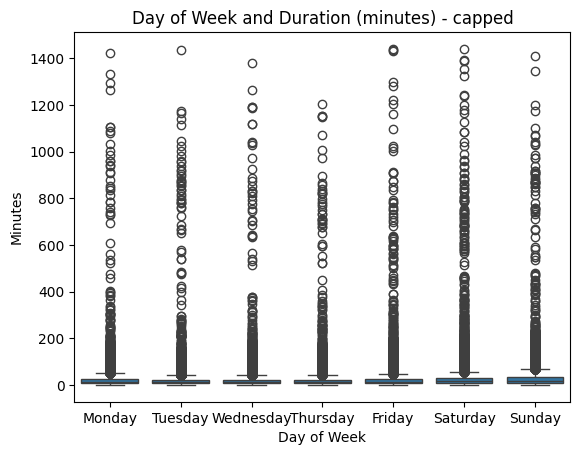

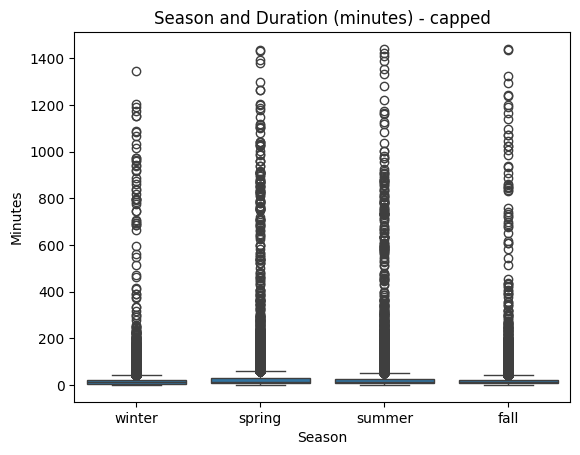

In [ ]:
# Emma
## Validating
# we could look at day of the week, time of day, etc.
# checking NA counts
print('NA counts by column: \n',final_joined.isna().sum())
na_columns = final_joined.isna().any()
print('\nColumns with NAs: \n',na_columns[na_columns])
# checking data types
print('\n',final_joined.dtypes)
# checking for duplicates
print('\n',final_joined.duplicated().sum())
## outliers processed in cleaning, no further action needed
# checking relationships (scatter plots)
plt.figure(figsize=(8,4))
plt.scatter(final_joined['distance_traveled_miles'], final_joined['duration_min'])
plt.title("Distance (miles) and Duration (minutes) - capped")
plt.xlabel("Miles")
plt.ylabel("Minutes")
plt.show()

plt.clf()
final_joined_sub = final_joined[final_joined['round_trip_bool'] == 0]
plt.scatter(final_joined_sub['distance_traveled_miles'], final_joined_sub['duration_min'])
plt.title("Non-RoundTrip: Distance (miles) and Duration (minutes) - capped")
plt.xlabel("Miles")
plt.ylabel("Minutes")
plt.show()

plt.clf()
sns.boxplot(x='day_of_week',y='duration_min', data = final_joined,
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Day of Week and Duration (minutes) - capped")
plt.xlabel("Day of Week")
plt.ylabel("Minutes")
plt.show()

plt.clf()
sns.boxplot(x='season',y='duration_min', data = final_joined,
            order = ['winter','spring','summer','fall'])
plt.title("Season and Duration (minutes) - capped")
plt.xlabel("Season")
plt.ylabel("Minutes")
plt.show()

# **Data Modeling**

# Ride Demand Prediction

## Group by table to get daily levels

In [ ]:
# Emma
# ensure no white space in col names, should be superfluous
final_joined.columns = final_joined.columns.str.strip()

final_day_agg = final_joined.groupby(['date','weekday','region','year']).agg({
    'precip_bool': 'max',
    'snow_bool': 'max',
    'TAVG': 'mean',
    'ride_id': 'count',
    'season_spring': 'max',
    'season_summer': 'max',
    'season_winter': 'max',
    # in aggregate it is a percentage of member riders
    'member_dummy': 'mean'
}).reset_index()

final_day_agg.rename(columns={'ride_id': 'ride_count'}, inplace=True)
final_day_agg = pd.get_dummies(final_day_agg, columns=['region'], dtype=int)

final_day_agg.head()

,date,weekday,year,precip_bool,snow_bool,TAVG,ride_count,season_spring,season_summer,season_winter,member_dummy,region_NE,region_NW,region_SE,region_SW
0,2022-01-01,5,2022,1,0,55.0,3,0,0,1,0.000000,1,0,0,0
1,2022-01-01,5,2022,1,0,55.0,12,0,0,1,0.250000,0,1,0,0
2,2022-01-01,5,2022,1,0,55.0,17,0,0,1,0.647059,0,0,1,0
3,2022-01-01,5,2022,1,0,55.0,1,0,0,1,1.000000,0,0,0,1
4,2022-01-02,6,2022,1,0,37.0,1,0,0,1,0.000000,1,0,0,0


## Feature exploration (correlation)

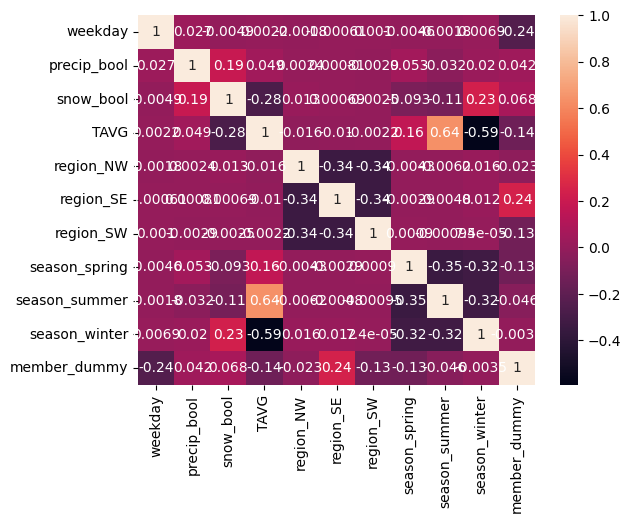

Optimal features: ['TAVG', 'region_SE']


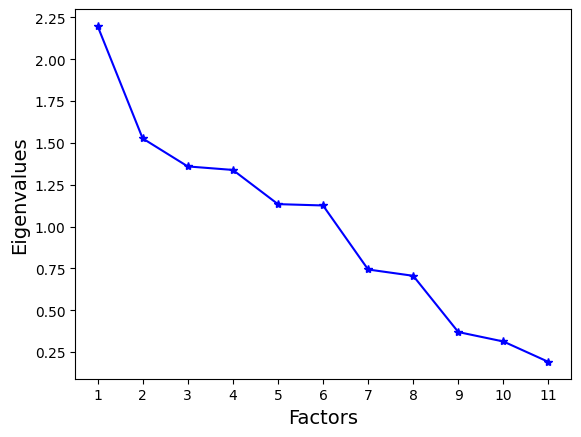

In [ ]:
# Emma
# feature exploration

## examine cross correlation
train_df_exp_demand_pred = final_day_agg[final_day_agg['year'] < 2024]
test_df_exp_demand_pred = final_day_agg[final_day_agg['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW',
            'season_spring','season_summer', 'season_winter',
            'member_dummy']

# note if any exceed 0.8 to drop before model building
corr_matrix_exp_demand_pred = (train_df_exp_demand_pred[features].corr())
sns.heatmap(corr_matrix_exp_demand_pred, annot=True)
plt.show()


## PCA
X_train = train_df_exp_demand_pred[features]
X_test = test_df_exp_demand_pred[features]
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# initial PCA to get scree
pca = PCA()
X_train_pca = pca.fit_transform(scaled_X_train)
X_test_pca = pca.transform(scaled_X_test)

#print(pca.explained_variance_ratio_)
#print(pca.components_.T)

eigenvals = pca.explained_variance_
prop_var = eigenvals / np.sum(eigenvals)

xint = range(1, len(features)+1)
plt.xticks(xint)
plt.plot(xint, pca.explained_variance_, 'b*-')
plt.xlabel('Factors', fontsize='14');
plt.ylabel('Eigenvalues', fontsize='14');

opt_pca = PCA(n_components = 2)
X_train_opt_pca = opt_pca.fit_transform(scaled_X_train)
X_test_opt_pca = opt_pca.transform(scaled_X_test)

feat_loadings = opt_pca.components_.T * np.sqrt(opt_pca.explained_variance_)
loading_df = pd.DataFrame(feat_loadings, index = features, columns = ['PC1', 'PC2'])

#print(loading_df)
#print(opt_pca.explained_variance_ratio_)

pc1_max = (max(abs(loading_df['PC1'])))
pc2_max = (max(abs(loading_df['PC2'])))
pc1_feat = loading_df[(loading_df['PC1']==pc1_max) | (loading_df['PC1']==-1*pc1_max)].index[0]
pc2_feat = loading_df[(loading_df['PC2']==pc2_max) | (loading_df['PC2']==-1*pc2_max)].index[0]
optimal_features_q1 = [pc1_feat, pc2_feat]
print("Optimal features:", optimal_features_q1)

## Multiple Regression

Predicted ride count =  -44.26921399053458  +  4.053595496006677 * (weekday)  +  8.631071845793544 * (member)  +  -17.496515902413915 * (precipitation)  +  8.543519564203125 * (snow)
R-squared:  0.19756367206518122
MSE:  1097.874050942099
RMSE:  33.13418251507194
MAPE:  1.7023863776564914
residual average:  -4.154400859674848


/tmp/ipython-input-1091264786.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_multiple_regression_demand_pred['season'] = test_df_multiple_regression_demand_pred.apply(get_season, axis=1)


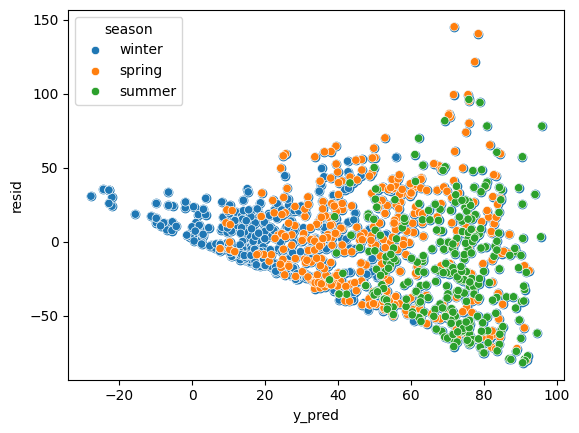

In [ ]:
# Adrian
# Multiple Regression
multiple_regression_demand_pred = final_day_agg[['weekday','precip_bool','snow_bool','TAVG',
                                 'ride_count','year','date',
                                 'region_NW',
                                 'region_SE','region_SW',
                                 'season_spring',
                                 'season_summer', 'season_winter',
                                 'member_dummy']]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_multiple_regression_demand_pred = multiple_regression_demand_pred[multiple_regression_demand_pred['year'] < 2024]
test_df_multiple_regression_demand_pred = multiple_regression_demand_pred[multiple_regression_demand_pred['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW',
            'season_spring','season_summer', 'season_winter',
            'member_dummy']
features_subset = ['weekday','member_dummy','precip_bool','snow_bool','TAVG']
X_train = train_df_multiple_regression_demand_pred[features_subset]
X_test = test_df_multiple_regression_demand_pred[features_subset]
y_train = train_df_multiple_regression_demand_pred['ride_count']
y_test = test_df_multiple_regression_demand_pred['ride_count']

#train model
multipleRegModel = LinearRegression()
multipleRegModel.fit(X_train, y_train)

print(
    "Predicted ride count = ",
    multipleRegModel.intercept_,
    " + ",
    multipleRegModel.coef_[0],
    "* (weekday)",
    " + ",
    multipleRegModel.coef_[1],
    "* (member)",
    " + ",
    multipleRegModel.coef_[2],
    "* (precipitation)",
    " + ",
    multipleRegModel.coef_[3],
    "* (snow)",
)

#predictions on the test set
y_pred = multipleRegModel.predict(X_test)

# Emma

# residual analysis
resid = y_test - y_pred
plt.scatter(y_pred, resid)

# bike type not included in model
# scatter residuals by season
def get_season(r):
  if r['season_spring'] == 1:
    return 'spring'
  elif r['season_summer'] == 1:
    return 'summer'
  elif r['season_winter'] == 1:
    return 'winter'
  else:
    return 'fall'

test_df_multiple_regression_demand_pred['season'] = test_df_multiple_regression_demand_pred.apply(get_season, axis=1)
# print(test_df_multiple_regression_demand_pred['season'])

plot_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'resid':resid, 'season': test_df_multiple_regression_demand_pred['season']})
#sns.scatterplot(data=plot_df, x='y_test', y='y_pred', hue='season')
#plt.clf()
sns.scatterplot(data=plot_df, x='y_pred',y='resid', hue = 'season')


#scoring Multiple Regression model
multipleRegModelScore = multipleRegModel.score(X_test, y_test)
print("R-squared: ", multipleRegModelScore)

# Adrian
#MSE & RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("residual average: ", np.mean(resid))
# Given the low R^2 (0.35) and relatively high RMSE (25), we are concerned about overfitting, interest in dimensionality reduction

The impact of season does not seem to be captured (random in residuals). May be worth evaluating an individual model for season if customer need is there.

Predicted ride count =  -44.26921399053458  +  4.053595496006677 * ( TAVG )  +  8.631071845793544 * ( region_SE )
2852    winter
2853    winter
2854    winter
2855    winter
2856    winter
         ...  
3816    summer
3817    summer
3818    summer
3819    summer
3820    summer
Name: season, Length: 969, dtype: object
R-squared:  0.23198217626621886
MSE:  1050.7834827323927
RMSE:  32.41579063870559
MAPE:  1.5454178375934875
residual average:  -3.35240952614291


/tmp/ipython-input-3432490490.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_multiple_regression_demand_pred['season'] = test_df_multiple_regression_demand_pred.apply(get_season, axis=1)


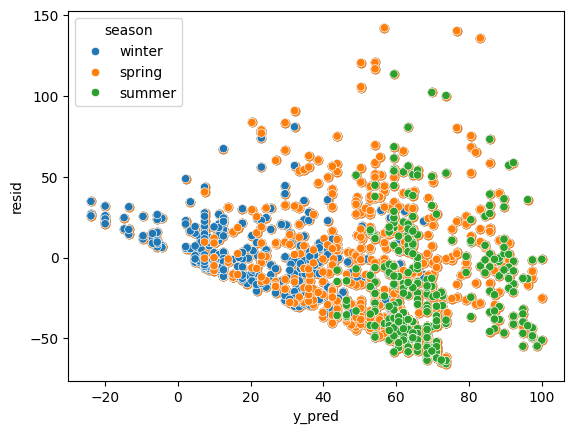

In [ ]:
# Emma
# Multiple Regression - using PCA identified features only
# split dataset for train & validation by withholding 2024, train on 2022 & 2023

X_train = train_df_multiple_regression_demand_pred[optimal_features_q1]
X_test = test_df_multiple_regression_demand_pred[optimal_features_q1]
y_train = train_df_multiple_regression_demand_pred['ride_count']
y_test = test_df_multiple_regression_demand_pred['ride_count']

#train model
multipleRegModel_pca = LinearRegression()
multipleRegModel_pca.fit(X_train, y_train)

print(
    "Predicted ride count = ",
    multipleRegModel.intercept_,
    " + ",
    multipleRegModel.coef_[0],
    "* (",optimal_features_q1[0],")",
    " + ",
    multipleRegModel.coef_[1],
    "* (",optimal_features_q1[1],")",
)

#predictions on the test set
y_pred = multipleRegModel_pca.predict(X_test)

# residual analysis
resid = y_test - y_pred
plt.scatter(y_pred, resid)

# residual analysis
resid = y_test - y_pred
plt.scatter(y_pred, resid)

# bike type not included in model
# scatter residuals by season
def get_season(r):
  if r['season_spring'] == 1:
    return 'spring'
  elif r['season_summer'] == 1:
    return 'summer'
  elif r['season_winter'] == 1:
    return 'winter'
  else:
    return 'fall'

test_df_multiple_regression_demand_pred['season'] = test_df_multiple_regression_demand_pred.apply(get_season, axis=1)
print(test_df_multiple_regression_demand_pred['season'])

plot_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'resid':resid, 'season': test_df_multiple_regression_demand_pred['season']})
#sns.scatterplot(data=plot_df, x='y_test', y='y_pred', hue='season')
#plt.clf()
sns.scatterplot(data=plot_df, x='y_pred',y='resid', hue = 'season')


#scoring Multiple Regression model
multipleRegModelScore_pca = multipleRegModel_pca.score(X_test, y_test)
print("R-squared: ", multipleRegModelScore_pca)

#MSE & RMSE
mse_pca = mean_squared_error(y_test, y_pred)
rmse_pca = np.sqrt(mse_pca)
mape_pca = mean_absolute_percentage_error(y_test, y_pred)

print("MSE: ", mse_pca)
print("RMSE: ", rmse_pca)
print("MAPE: ", mape_pca)
print("residual average: ", np.mean(resid))

Error metrics are relatively similar using all 11 features or the 2 PCA identified features, potentially pointing to using the simpler (2 feature) model.

Preidtcing negative rides which we know is out of bounds. Additionally, residuals are not consistent, or averaging zero (~1.91 in simpler model and ~2.2 in more complex model). Additionally, residuals show to fan across x axis in both models.

## KNN

In [ ]:
# Emma
# KNN Regressor
# Pros - non-parametric so no linear relationship assumed
# Cons - need to watch on impact of any extereme points
knn_demand_pred = final_day_agg[['weekday','precip_bool','snow_bool','TAVG',
                                 'ride_count','year',
                                 'region_NW',
                                 'region_SE','region_SW',
                                 'season_spring',
                                 'season_summer', 'season_winter',
                                 'member_dummy']]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_knn_demand_pred = knn_demand_pred[knn_demand_pred['year'] < 2024]
test_df_knn_demand_pred = knn_demand_pred[knn_demand_pred['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW',
            'season_spring','season_summer', 'season_winter',
            'member_dummy']

X_train = train_df_knn_demand_pred[optimal_features_q1]
X_test = test_df_knn_demand_pred[optimal_features_q1]
y_train = train_df_knn_demand_pred['ride_count']
y_test = test_df_knn_demand_pred['ride_count']

# normalization because KNN is sensitive to values due to distance comp.
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# train model
knn = KNeighborsRegressor(n_neighbors=11)
# since this data is temporal split (one entire year held for test), typical CV underpreforms since it randomly samples
demand_pred_cv_scores = cross_val_score(knn, scaled_X_train, y_train, cv = 10, scoring = 'neg_mean_absolute_percentage_error')
print("Mean MAPE: ", demand_pred_cv_scores.mean())
knn.fit(scaled_X_train, y_train)
y_pred = knn.predict(scaled_X_test)

# validate
# RMSE & MAPE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("Avg residual: ", np.mean(y_test - y_pred))
print("R2: ", r2_score(y_test, y_pred))

Mean MAPE:  -1.3212274530214894
RMSE:  32.06238362109824
MAPE:  1.183520448713679
Avg residual:  1.6315789473684215
R2:  0.24863722708681524


features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NE','region_NW','region_SE','region_SW']

+ seasons and membership
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NE','region_NW','region_SE','region_SW',
            'season_fall', 'season_spring','season_summer', 'season_winter',
            'member_dummy']
*   k = 5: RMSE: 32.895, MAPE: 1.10
*   k = 7: RMSE: 32.8, MAPE: 1.08
*   **k = 9: RMSE: 32.39, MAPE: 1.09**
*   **k = 11: RMSE: 32.23, MAPE: 1.13**
*   k = 13: RMSE: 31.84, MAPE: 1.15
*   k = 15: RMSE: 31.62, MAPE: 1.17








PCA only components for KNN performs much worse at the same k, MAPE 100%+

## DT/RF

Decision Tree Regressor Performance:
RMSE: 29.09
MAPE: 0.62
R-squared: 0.38
Average Residual: -1.08

Decision Tree Regressor Feature Importance:
TAVG             0.370085
region_NE        0.231636
member_dummy     0.131330
weekday          0.122585
region_SW        0.063376
precip_bool      0.048928
season_spring    0.009901
region_SE        0.006824
season_winter    0.006782
season_summer    0.005070
region_NW        0.003388
snow_bool        0.000094
dtype: float64


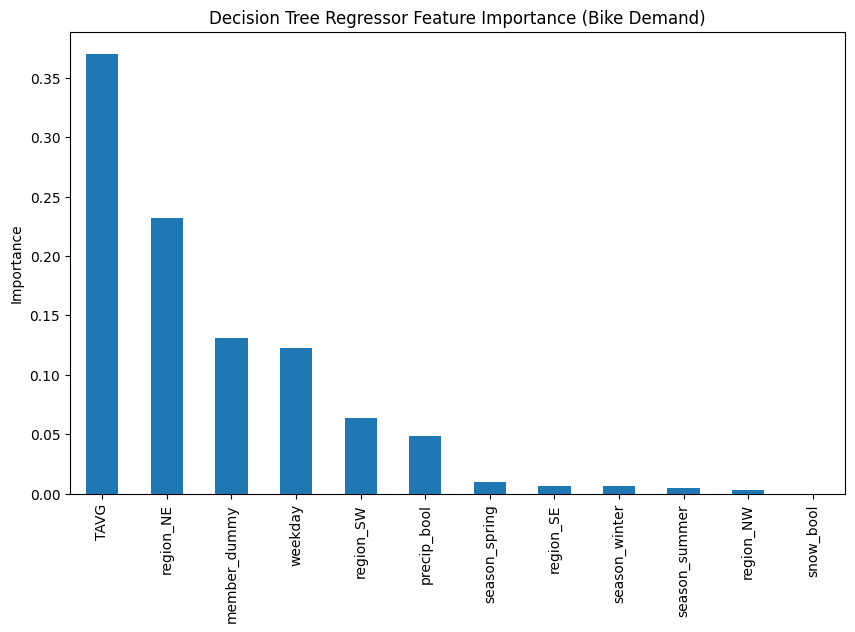

In [ ]:
# Shilp
# Decision Tree Regressor for Bike Demand Prediction

# Split data into training and testing sets based on year
train_df_demand_dt = final_day_agg[final_day_agg['year'] < 2024].copy()
test_df_demand_dt = final_day_agg[final_day_agg['year'] == 2024].copy()

# Define features and target
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NE','region_NW','region_SE','region_SW',
            'season_spring','season_summer', 'season_winter',
            'member_dummy']

X_train = train_df_demand_dt[features]
X_test = test_df_demand_dt[features]
y_train = train_df_demand_dt['ride_count']
y_test = test_df_demand_dt['ride_count']

# Train Decision Tree Regressor model
dt_demand_model = DecisionTreeRegressor(random_state=42)
dt_demand_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_demand_model.predict(X_test)

# Evaluate the model
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regressor Performance:")
print(f"RMSE: {rmse_dt:.2f}")
print(f"MAPE: {mape_dt:.2f}")
print(f"R-squared: {r2_dt:.2f}")
print(f"Average Residual: {np.mean(y_test-y_pred_dt):.2f}")


# Feature importance
feature_importance_dt = pd.Series(dt_demand_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nDecision Tree Regressor Feature Importance:")
print(feature_importance_dt)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_dt.plot(kind='bar')
plt.title("Decision Tree Regressor Feature Importance (Bike Demand)")
plt.ylabel("Importance")
plt.show()

Random Forest Regressor Performance:
RMSE: 23.24
MAPE: 0.53
R-squared: 0.61
Average Residual: -1.86

Random Forest Regressor Feature Importance:
TAVG             0.372765
region_NE        0.232483
weekday          0.120832
member_dummy     0.119171
region_SW        0.054947
precip_bool      0.049697
region_NW        0.012617
season_spring    0.011790
region_SE        0.011573
season_winter    0.007184
season_summer    0.006666
snow_bool        0.000275
dtype: float64


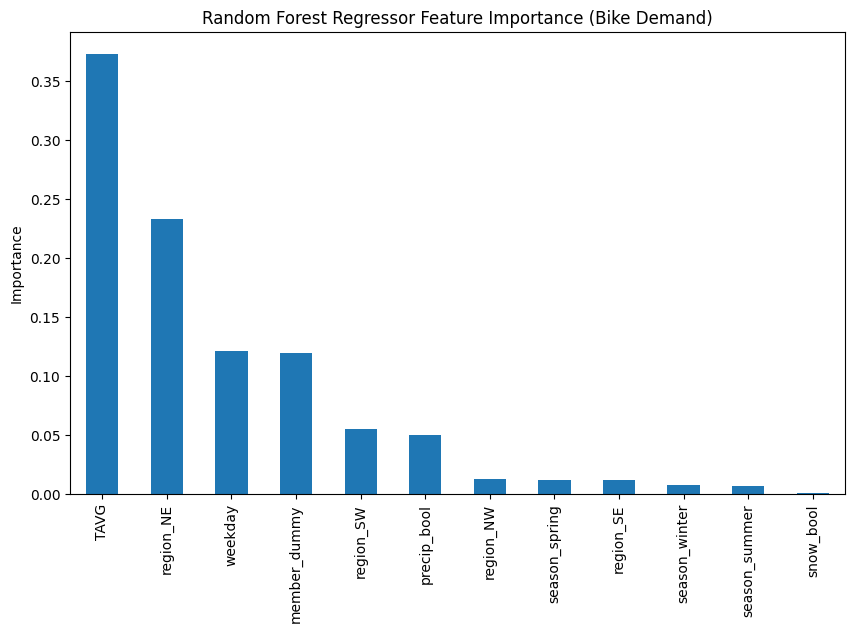

In [ ]:
# Shilp
# Random Forest Regressor for Bike Demand Prediction

# Split data into training and testing sets based on year
train_df_demand_rf = final_day_agg[final_day_agg['year'] < 2024].copy()
test_df_demand_rf = final_day_agg[final_day_agg['year'] == 2024].copy()

# Define features and target (using the same features as the Decision Tree)
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NE','region_NW','region_SE','region_SW',
            'season_spring','season_summer', 'season_winter',
            'member_dummy']

X_train = train_df_demand_rf[features]
X_test = test_df_demand_rf[features]
y_train = train_df_demand_rf['ride_count']
y_test = test_df_demand_rf['ride_count']

# Train Random Forest Regressor model
rf_demand_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_demand_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_demand_model.predict(X_test)

# Evaluate the model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")
print(f"Average Residual: {np.mean(y_test-y_pred_rf):.2f}")


# Feature importance
feature_importance_rf = pd.Series(rf_demand_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nRandom Forest Regressor Feature Importance:")
print(feature_importance_rf)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='bar')
plt.title("Random Forest Regressor Feature Importance (Bike Demand)")
plt.ylabel("Importance")
plt.show()

## Case Study Large Miss

In [ ]:
# Emma
# Case Study Large Miss
rf_resid = y_test-y_pred_rf
abs_rf_resid = abs(y_test-y_pred_rf)
abs_rf_resid = abs_rf_resid
#print(y_test.shape)
#print(y_pred_rf.shape)
#print(rf_resid.shape)
#print(abs_rf_resid.shape)

max_abs_resid = abs_rf_resid.max()

large_miss_index = abs_rf_resid[abs_rf_resid == max_abs_resid].index[0]
large_miss_row = abs_rf_resid.index.get_loc(large_miss_index)

#print(large_miss_row)
print("Actual value: ",y_test.iloc[large_miss_row])
print("Predicted value: ",y_pred_rf[large_miss_row])

print(test_df_demand_rf.iloc[large_miss_row])
# this day had average temperature, in fall, no rain, and 36% of riders were members
# the centralize location of TAVG, the most important feature, and the 0s on
# high importance regions (NE. SW) may have led the model to a much smaller
# predicted number of rides than realized rides
# it is also possible there was a special event or outside circumstance
# in the city that would have increased the number of rides without
# current visibility

Actual value:  52
Predicted value:  145.83
date             2024-08-03
weekday                   5
year                   2024
precip_bool               1
snow_bool                 0
TAVG                   74.0
ride_count               52
season_spring             0
season_summer             1
season_winter             0
member_dummy       0.480769
region_NE                 0
region_NW                 0
region_SE                 1
region_SW                 0
Name: 3707, dtype: object


## Model Selection and Justification

Multiple models were fit and scored on metrics such as Root Mean Squared Error (RMSE), Mean Absolute Percent Error (MAPE), R^2, and average of the residuals (ideally close to 0)

**Multivariate Regression, all features:**
*   RMSE: 32.08
*   MAPE: 161%
*   R^2: 0.285
*   Average Residual: -2.32

**Multivariate Regression, PCA features:**
*   RMSE: 31.49
*   MAPE: 141%
*   R^2: 0.311
*   Average Residual: -1.2

**KNN, all features:**
*   RMSE: 32.39
*   MAPE: 113%
*   R^2: 0.278
*   Average Residual: 3.45

**KNN, PCA features:**
*   Underperforms KNN all features significantly

**Decision Tree:**
*   RMSE: 26.29
*   MAPE: 63%
*   R^2: 0.52
*   Average Residual: -0.76

**Random Forest:**
*   RMSE: 20.48
*   MAPE: 53%
*   R^2: 0.71
*   Average Residual: -1.58

**Results:**
With the exception of Average Residual being slightly better in DT and Multivar-PCA, the Random Forest had the best model performance statistics. It is the strongest of the fitted models for predicting number of rides taken per day.



# Trip Duration Prediction

In [ ]:
# Emma
print(final_joined.columns)

Index(['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at',
       'duration_min', 'duration_min_capped', 'start_station_id',
       'start_station_name', 'start_lat', 'start_lng', 'end_station_id',
       'end_station_name', 'end_lat', 'end_lng', 'round_trip_bool',
       'distance_traveled_miles', 'date', 'year', 'month', 'day', 'hour',
       'day_of_week', 'weekday', 'weekend', 'day_Friday', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'season', 'season_spring', 'season_summer',
       'season_winter', 'region', 'region_NW', 'region_SE', 'region_SW',
       'member_dummy', 'dummy_docked_bike', 'dummy_electric_bike', 'STATION',
       'DATE', 'TAVG', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'precip_bool',
       'snow_bool'],
      dtype='object')


## Multiple Regression

duration =  17.775197967837407  +  0.4558949274129097 * (weekday)  +  -9.993383201671012 * (member)  +  -0.6416021925517406 * (precipitation)  +  -1.1591909813843155 * (snow)


/tmp/ipython-input-1411835267.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_mulReg_dur_pred['season'] = test_df_mulReg_dur_pred.apply(get_season, axis=1)
/tmp/ipython-input-1411835267.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_mulReg_dur_pred['bike_type'] = test_df_mulReg_dur_pred.apply(get_bike, axis=1)


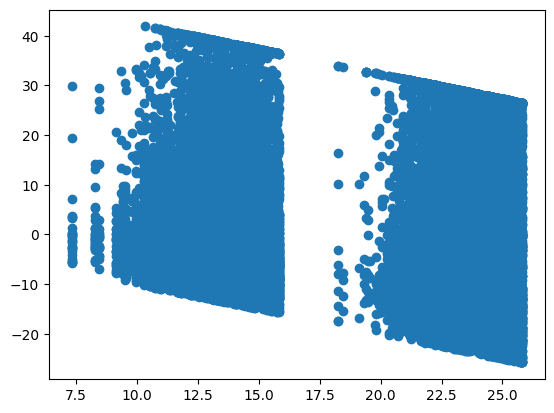

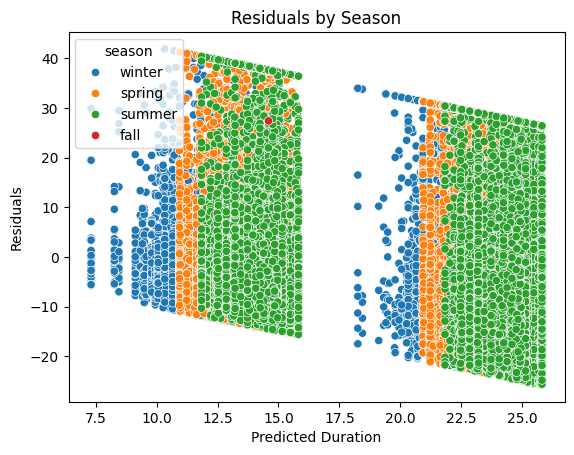

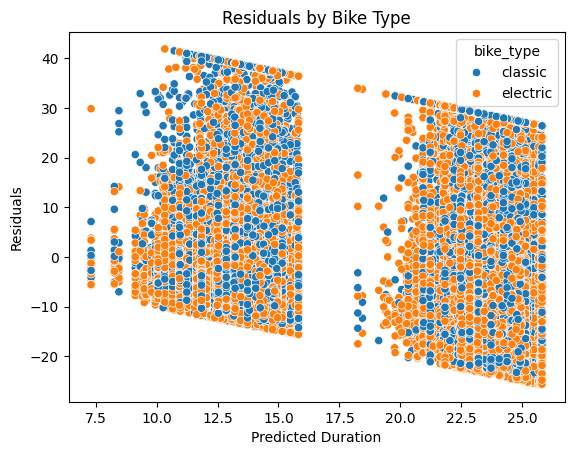

R-squared:  0.1558405062268654
MSE:  185.5900203710267
RMSE:  13.62314282282274
MAPE:  2.7370023484395825


In [ ]:
# Adrian
# Multiple Regression
mulReg_dur_pred = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'season_spring','season_summer', 'season_winter',
                              'member_dummy','distance_traveled_miles',
                             'dummy_docked_bike', 'dummy_electric_bike']]
mulReg_dur_pred = mulReg_dur_pred.dropna(axis=0)

# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_mulReg_dur_pred = mulReg_dur_pred[mulReg_dur_pred['year'] < 2024]
test_df_mulReg_dur_pred = mulReg_dur_pred[mulReg_dur_pred['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW','distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

features_subset = ['weekday','member_dummy','precip_bool','snow_bool','TAVG']

X_train = train_df_mulReg_dur_pred[features_subset]
X_test = test_df_mulReg_dur_pred[features_subset]
y_train = train_df_mulReg_dur_pred['duration_min_capped']
y_test = test_df_mulReg_dur_pred['duration_min_capped']

#train model
DurationRegModel = LinearRegression()
DurationRegModel.fit(X_train, y_train)

print(
    "duration = ",
    DurationRegModel.intercept_,
    " + ",
    DurationRegModel.coef_[0],
    "* (weekday)",
    " + ",
    DurationRegModel.coef_[1],
    "* (member)",
    " + ",
    DurationRegModel.coef_[2],
    "* (precipitation)",
    " + ",
    DurationRegModel.coef_[3],
    "* (snow)",
)

#predictions on the test set
y_pred = DurationRegModel.predict(X_test)

# residual analysis
resid = y_test - y_pred
plt.scatter(y_pred, resid)

# bike type not included in model
# scatter residuals by season
def get_season(r):
  if r['season_spring'] == 1:
    return 'spring'
  elif r['season_summer'] == 1:
    return 'summer'
  elif r['season_winter'] == 1:
    return 'winter'
  else:
    return 'fall'

def get_bike(r):
  if r['dummy_docked_bike'] == 1:
    return 'docked'
  elif r['dummy_electric_bike'] == 1:
    return 'electric'
  else:
    return 'classic'

test_df_mulReg_dur_pred['season'] = test_df_mulReg_dur_pred.apply(get_season, axis=1)
test_df_mulReg_dur_pred['bike_type'] = test_df_mulReg_dur_pred.apply(get_bike, axis=1)
#print(test_df_mulReg_dur_pred['season'])
#print(test_df_mulReg_dur_pred['bike_type'])

plot_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'resid':resid,
                        'season': test_df_mulReg_dur_pred['season'],
                        'bike_type': test_df_mulReg_dur_pred['bike_type']
                        })
#sns.scatterplot(data=plot_df, x='y_test', y='y_pred', hue='season')
plt.figure()
sns.scatterplot(data=plot_df, x='y_pred',y='resid', hue = 'season')
plt.title("Residuals by Season")
plt.xlabel("Predicted Duration")
plt.ylabel("Residuals")
plt.show()

plt.figure()
sns.scatterplot(data=plot_df, x='y_pred',y='resid', hue = 'bike_type')
plt.title("Residuals by Bike Type")
plt.xlabel("Predicted Duration")
plt.ylabel("Residuals")
plt.show()

# TO DO: case review for large miss

#scoring Multiple Regression model
DurationRegModelScore = DurationRegModel.score(X_test, y_test)
print("R-squared: ", DurationRegModelScore)

#MSE & RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAPE: ", mape)

## Adjusted R^2 feature exploration

Best feature to drop to yield highest Adj R^2:  8
Best feature to drop to yield highest Adj R^2:  2
Best feature to drop to yield highest Adj R^2:  4
Best feature to drop to yield highest Adj R^2:  6
Best feature to drop to yield highest Adj R^2:  7


'dummy_docked_bike'

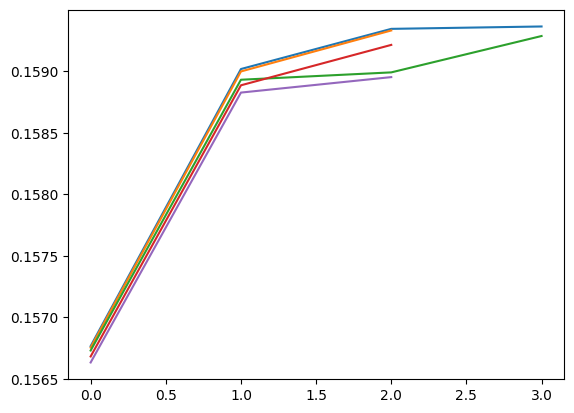

In [ ]:
# Emma
# Adj R^2 multiple Regression check

# basic thought is to withhold each feature, fit model, calculate
# Adjusted R^2, and identify best feature to drop (resulting in highest
# Adjusted R^2, drop it, and repeat)

AdjR2_multiReg = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'season_spring','season_summer', 'season_winter',
                              'member_dummy',
                             # has NAs
                             #'distance_traveled_miles',
                             'dummy_docked_bike', 'dummy_electric_bike']]

target = ['duration_min_capped']
features= ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW',
           # has NAs
           #'distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

lin_reg = LinearRegression()

def adj_r2_optimizer(features):
  best_adj_r2 = 0
  best_model = None
  AdjR2_results = []
  opt_i = -1

  for i in range(len(features)):
    features_copy = features.copy()
    features_copy.pop(i)
    model = lin_reg.fit(AdjR2_multiReg[features_copy], AdjR2_multiReg[target])
    adj_r2 = 1 - (1 - model.score(AdjR2_multiReg[features_copy], AdjR2_multiReg[target])) * (len(AdjR2_multiReg) - 1) / (len(AdjR2_multiReg) - len(model.coef_) - 1)
    if(adj_r2 > best_adj_r2):
      best_adj_r2 = adj_r2
      best_model = model
      opt_i = i
      AdjR2_results.append(adj_r2)

  print("Best feature to drop to yield highest Adj R^2: ",opt_i)
  plt.plot(AdjR2_results)
  return opt_i


features.pop(adj_r2_optimizer(features))
features.pop(adj_r2_optimizer(features))
features.pop(adj_r2_optimizer(features))
features.pop(adj_r2_optimizer(features))
features.pop(adj_r2_optimizer(features))

# Adjuisted R^2 appears to be dropping as features are dropped
# meaning the dropped features may be informative

# ideally this would become an iterative loop for feature selection

# python does not seem to have a built in stepwise function
#selected, best_model = sm.forward_aic(AIC_multiReg, target, features, verbose=True)
#print(best_model.summary())



## KNN

['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at', 'duration_min', 'duration_min_capped', 'start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'end_station_id', 'end_station_name', 'end_lat', 'end_lng', 'round_trip_bool', 'distance_traveled_miles', 'date', 'year', 'month', 'day', 'hour', 'day_of_week', 'weekday', 'weekend', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'season', 'season_spring', 'season_summer', 'season_winter', 'region', 'region_NW', 'region_SE', 'region_SW', 'member_dummy', 'dummy_docked_bike', 'dummy_electric_bike', 'STATION', 'DATE', 'TAVG', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'precip_bool', 'snow_bool']


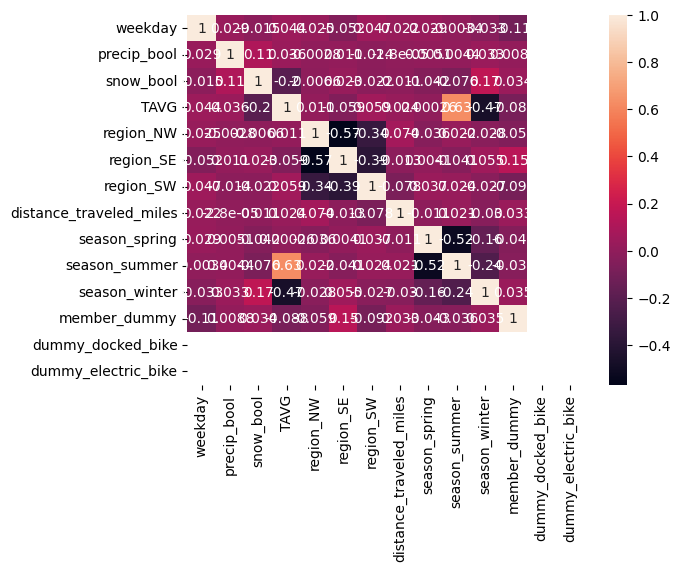

RMSE:  12.60948308387312
MAPE:  3.173328153300989


In [ ]:
# Emma
# KNN Regressor
# Pros - non-parametric so no linear relationship assumed
# Cons - need to watch on impact of any extereme points
print(final_joined.columns.tolist())
knn_dur_pred = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'season_spring','season_summer', 'season_winter',
                              'member_dummy','distance_traveled_miles',
                             'dummy_docked_bike', 'dummy_electric_bike']]
knn_dur_pred = knn_dur_pred.dropna(axis = 0)
knn_dur_pred = knn_dur_pred[knn_dur_pred['dummy_electric_bike'] == 1]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_knn_dur_pred = knn_dur_pred[knn_dur_pred['year'] < 2024]
test_df_knn_dur_pred = knn_dur_pred[knn_dur_pred['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW','distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

corr_matrix_knn_dur_pred = (train_df_knn_dur_pred[features].corr())
sns.heatmap(corr_matrix_knn_dur_pred, annot=True)
plt.show()

X_train = train_df_knn_dur_pred[features]
X_test = test_df_knn_dur_pred[features]
y_train = train_df_knn_dur_pred['duration_min_capped']
y_test = test_df_knn_dur_pred['duration_min_capped']

# normalization because KNN is sensitive to values due to distance comp.
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# train model
knn = KNeighborsRegressor(n_neighbors=17)
knn.fit(scaled_X_train, y_train)
y_pred = knn.predict(scaled_X_test)

# TO DO: case review for large miss


# validate
# RMSE & MAPE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NE','region_NW','region_SE','region_SW',
            'member_dummy','dummy_classic_bike','dummy_docked_bike', 'dummy_electric_bike']


*   k = 3: RMSE: 15.71, MAPE: 308%
*   k = 5: RMSE: 14.77, MAPE: 298%
*   k = 7: RMSE: 14.55, MAPE: 297%
*   k = 9: RMSE: 14.31, MAPE: 297%
*   k = 11: RMSE: 14.16, MAPE: 295%
*   k = 13: RMSE: 14.05, MAPE 295%
*   k = 15: RMSE: 13.965, MAPE: 293%
-------
+ seasons and distance
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW','distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

*   k = 5: RMSE: 12.77, MAPE: 294%
*   k = 7: RMSE: 12.44, MAPE: 292%
*   k = 9: RMSE: 12.234, MAPE: 290%
*   k = 11: RMSE: 12.131, MAPE 288%
*   k = 13: RMSE: 12.046, MAPE: 284%
*   k = 15: RMSE: 11.995, MAPE: 284%
*   k = 17: RMSE: 11.937, MAPE: 283%


## DT/RF

Decision Tree Regressor Performance (Trip Duration):
RMSE: 16.09
MAPE: 3.03

Decision Tree Regressor Feature Importance (Trip Duration):
distance_traveled_miles    0.433495
TAVG                       0.172390
member_dummy               0.154087
weekday                    0.076202
dummy_electric_bike        0.045600
precip_bool                0.023947
region_SW                  0.023375
season_spring              0.019434
region_NW                  0.014958
region_SE                  0.013740
season_summer              0.011857
season_winter              0.008103
dummy_docked_bike          0.001812
snow_bool                  0.001001
dtype: float64


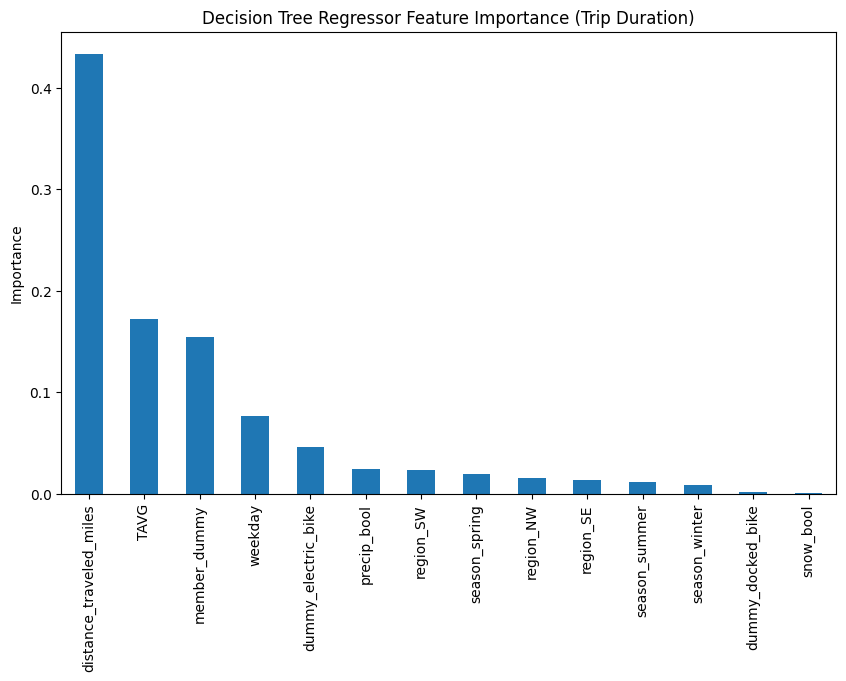

In [ ]:
#Shilp
# Decision Tree Regressor for Trip Duration Prediction

# Define features and target
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW','distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

X = final_joined[features].dropna()
y = final_joined.loc[X.index, 'duration_min_capped'] # Ensure y aligns with cleaned X

# Split data into training and testing sets based on year (using the indices from the cleaned data)
train_indices = X[final_joined.loc[X.index, 'year'] < 2024].index
test_indices = X[final_joined.loc[X.index, 'year'] == 2024].index

X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]


# Train Decision Tree Regressor model
dt_duration_model = DecisionTreeRegressor(random_state=42)
dt_duration_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_duration_model.predict(X_test)

# Evaluate the model
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regressor Performance (Trip Duration):")
print(f"RMSE: {rmse_dt:.2f}")
print(f"MAPE: {mape_dt:.2f}")
#print(f"R-squared: {r2_dt:.2f}")

# Feature importance
feature_importance_dt = pd.Series(dt_duration_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nDecision Tree Regressor Feature Importance (Trip Duration):")
print(feature_importance_dt)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_dt.plot(kind='bar')
plt.title("Decision Tree Regressor Feature Importance (Trip Duration)")
plt.ylabel("Importance")
plt.show()

Random Forest Regressor Performance (Trip Duration):
RMSE: 12.80
MAPE: 2.88
R-squared: 0.25

Random Forest Regressor Feature Importance (Trip Duration):
distance_traveled_miles    0.419998
TAVG                       0.180022
member_dummy               0.147610
weekday                    0.082838
dummy_electric_bike        0.043808
precip_bool                0.027697
region_SW                  0.022535
season_spring              0.020054
region_NW                  0.016017
region_SE                  0.015055
season_summer              0.013230
season_winter              0.008312
dummy_docked_bike          0.001743
snow_bool                  0.001080
dtype: float64


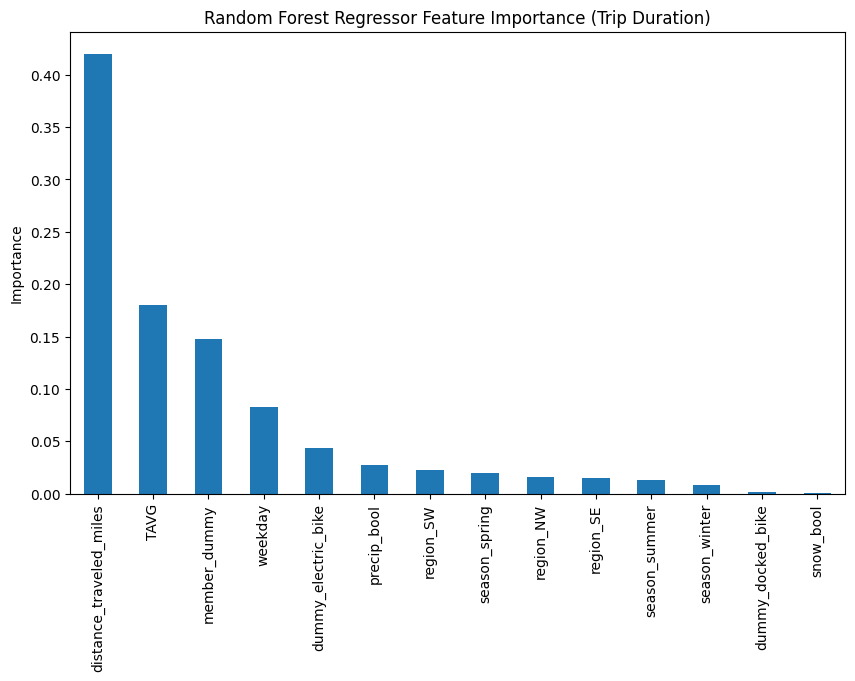

In [ ]:
# Shilp
# Random Forest Regressor for Trip Duration Prediction

# Define features and target (using the same features as the Decision Tree)
features = ['weekday','precip_bool','snow_bool','TAVG',
            'region_NW','region_SE','region_SW','distance_traveled_miles',
             'season_spring','season_summer', 'season_winter',
            'member_dummy','dummy_docked_bike', 'dummy_electric_bike']

X = final_joined[features].dropna()
y = final_joined.loc[X.index, 'duration_min_capped'] # Ensure y aligns with cleaned X

# Split data into training and testing sets based on year (using the indices from the cleaned data)
train_indices = X[final_joined.loc[X.index, 'year'] < 2024].index
test_indices = X[final_joined.loc[X.index, 'year'] == 2024].index

X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# Train Random Forest Regressor model
rf_duration_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_duration_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_duration_model.predict(X_test)

# Evaluate the model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance (Trip Duration):")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

# Feature importance
feature_importance_rf = pd.Series(rf_duration_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nRandom Forest Regressor Feature Importance (Trip Duration):")
print(feature_importance_rf)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='bar')
plt.title("Random Forest Regressor Feature Importance (Trip Duration)")
plt.ylabel("Importance")
plt.show()

## Case Study for Large Miss

In [ ]:
# Emma
# Case Study Large Miss

# Not executed due to lack of model consistency and requirement for
# further refinement before any possible deployment/use of output

## Model Selection and Justification

None of the models are they currently exist are recommended for use/deployment. While some performed better than others, the MAPE on the withheld 2024 test set is all 200%+ error, which may be worse than a simple average fit.

------
**Recommend further refinement**

-----

Multiple Regression:
*   RMSE: 13.07
*   MAPE: 253%

KNN:
*   RMSE: 11.93
*   MAPE: 283%

Decision Tree:
*   RMSE: 15.43
*   MAPE: 268%

Random Forest:
*   RMSE: 12.20
*   MAPE: 254%



# Rider Behavior Segmentation

## Logistic Regression

Accuracy score:  0.6877252440392372
Precision:  0.6918448438978241
Recall:  0.7872367911122594


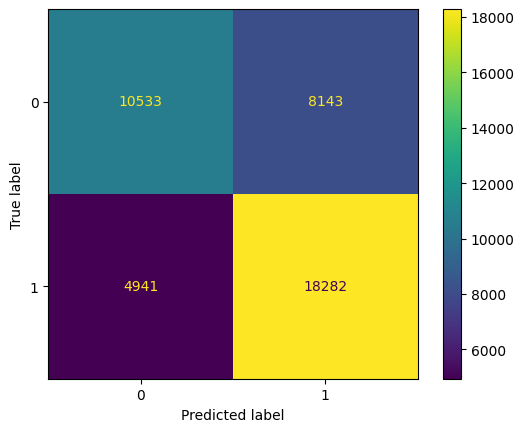

In [ ]:
# Adrian
# Logistic Regression

logReg_behavior_seg = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'member_dummy',
                             'dummy_docked_bike', 'dummy_electric_bike']]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_logReg_behavior_seg = logReg_behavior_seg[logReg_behavior_seg['year'] < 2024]
test_df_logReg_behavior_seg = logReg_behavior_seg[logReg_behavior_seg['year'] == 2024]

#define test and train
X_train = train_df_logReg_behavior_seg[['weekday','duration_min_capped','precip_bool','snow_bool','TAVG']]
X_test = test_df_logReg_behavior_seg[['weekday','duration_min_capped','precip_bool','snow_bool','TAVG']]
y_train = train_df_logReg_behavior_seg['member_dummy']
y_test = test_df_logReg_behavior_seg['member_dummy']
y_test_log = y_test
#scaling
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#train model
logRegModel = LogisticRegression()
logRegModel.fit(scaled_X_train, y_train)
# Emma
y_pred = logRegModel.predict(scaled_X_test)
y_pred_prob_log = logRegModel.predict_proba(scaled_X_test)
y_pred_log = y_pred

# validate
# accuracy score
# Adrian
print("Accuracy score: ",accuracy_score(y_test, y_pred))
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred))
cm_logReg_behavior_seg = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_logReg_behavior_seg).plot()
plt.show()

## KNN

['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at', 'duration_min', 'duration_min_capped', 'start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'end_station_id', 'end_station_name', 'end_lat', 'end_lng', 'round_trip_bool', 'distance_traveled_miles', 'date', 'year', 'month', 'day', 'hour', 'day_of_week', 'weekday', 'weekend', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'season', 'season_spring', 'season_summer', 'season_winter', 'region', 'region_NW', 'region_SE', 'region_SW', 'member_dummy', 'dummy_docked_bike', 'dummy_electric_bike', 'STATION', 'DATE', 'TAVG', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'precip_bool', 'snow_bool']
Accuracy score:  0.6538580873051862
Precision:  0.6917157681822179
Recall:  0.6773887955905783


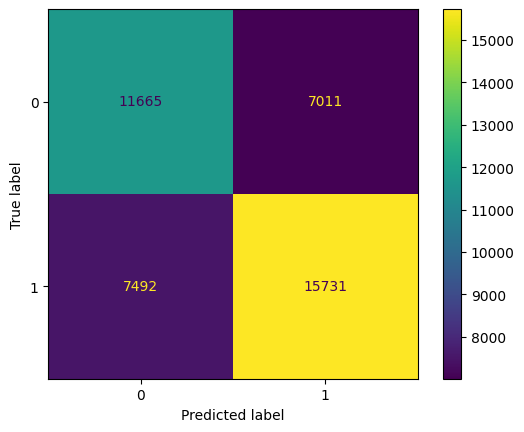

In [ ]:
# Emma
# KNN Classifier
# Pros - non-parametric so no linear relationship assumed
# Cons - need to watch on impact of any extereme points
print(final_joined.columns.tolist())
knn_behavior_seg = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'member_dummy',
                             'dummy_docked_bike', 'dummy_electric_bike']]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_knn_behavior_seg = knn_behavior_seg[knn_behavior_seg['year'] < 2024]
test_df_knn_behavior_seg = knn_behavior_seg[knn_behavior_seg['year'] == 2024]

# define feature of interest to include in the model
features = ['weekday','precip_bool','snow_bool','TAVG','duration_min_capped',
            'region_NW','region_SE','region_SW','dummy_docked_bike', 'dummy_electric_bike']

X_train = train_df_knn_behavior_seg[features]
X_test = test_df_knn_behavior_seg[features]
y_train = train_df_knn_behavior_seg['member_dummy']
y_test = test_df_knn_behavior_seg['member_dummy']

# normalization because KNN is sensitive to values due to distance comp.
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# train model
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(scaled_X_train, y_train)
y_pred = knn.predict(scaled_X_test)

# validate
# accuracy score
print("Accuracy score: ",accuracy_score(y_test, y_pred))
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred))
cm_knn_behavior_seg = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_knn_behavior_seg).plot()
plt.show()

features = ['weekday','precip_bool','snow_bool','TAVG','duration_min_capped',
            'region_NW','region_SE','region_SW','dummy_docked_bike', 'dummy_electric_bike']



*   k = 3: accuracy: 0.6088
*   k = 5: accuracy: 0.622
*   k = 7: accuracy: 0.633
*   **k = 9: accuracy: 0.691**
*   k = 11: accuracy: 0.641
*   k = 13: accuracy: 0.647
*   k = 15: accuracy: 0.649
*   k = 17: accuracy: 0.652
*   k = 19: accuracy: 0.653



## RF

Random Forest Classifier Performance (Rider Behavior Segmentation):
Accuracy: 0.62
Precision: 0.67
Recall: 0.62


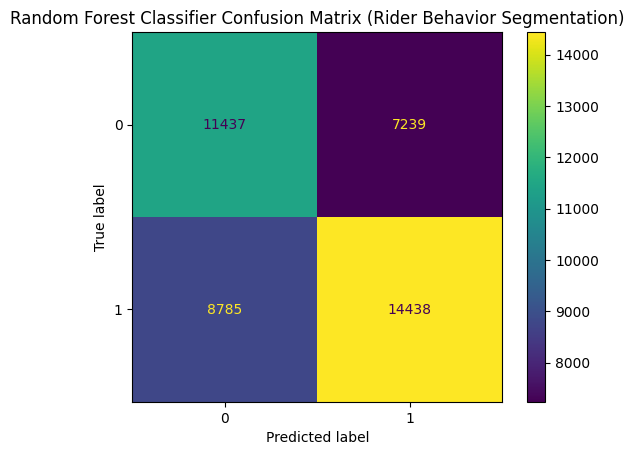


Random Forest Classifier Feature Importance (Rider Behavior Segmentation):
duration_min_capped    0.672252
TAVG                   0.221923
weekday                0.053631
dummy_electric_bike    0.013430
region_SE              0.010339
region_SW              0.009500
precip_bool            0.009456
region_NW              0.005731
dummy_docked_bike      0.002363
snow_bool              0.001375
dtype: float64


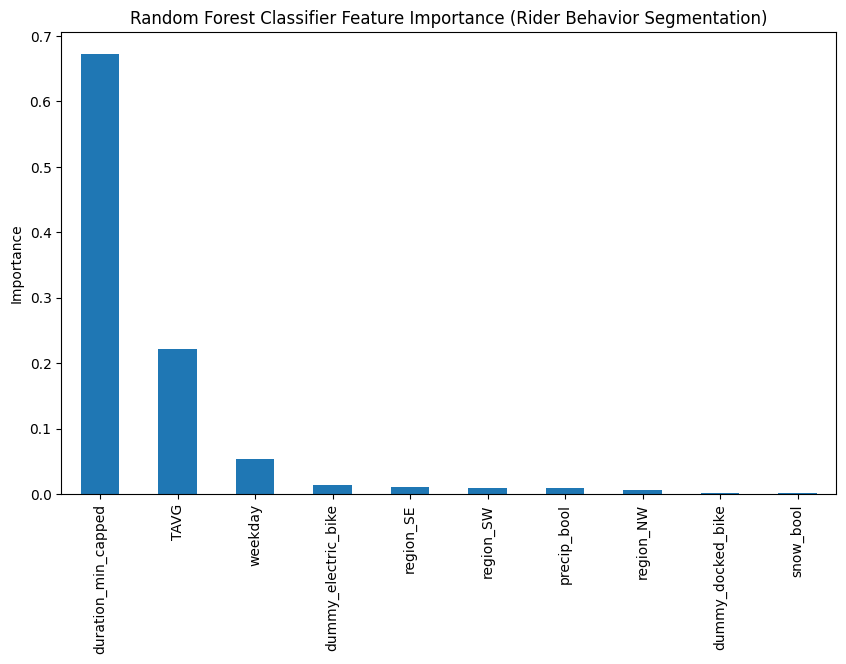

In [ ]:
# Shilp
# Random Forest Classifier for Rider Behavior Segmentation

# Define features and target
features = ['weekday','precip_bool','snow_bool','TAVG','duration_min_capped',
            'region_NW','region_SE','region_SW','dummy_docked_bike', 'dummy_electric_bike']

X = final_joined[features].dropna()
y = final_joined.loc[X.index, 'member_dummy'] # Ensure y aligns with cleaned X

# Split data into training and testing sets based on year (using the indices from the cleaned data)
train_indices = X[final_joined.loc[X.index, 'year'] < 2024].index
test_indices = X[final_joined.loc[X.index, 'year'] == 2024].index

X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# Train Random Forest Classifier model
rf_behavior_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_behavior_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_behavior_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("Random Forest Classifier Performance (Rider Behavior Segmentation):")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")

# Confusion Matrix
cm_rf_behavior_seg = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf_behavior_seg).plot()
plt.title("Random Forest Classifier Confusion Matrix (Rider Behavior Segmentation)")
plt.show()

# Feature importance
feature_importance_rf = pd.Series(rf_behavior_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nRandom Forest Classifier Feature Importance (Rider Behavior Segmentation):")
print(feature_importance_rf)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='bar')
plt.title("Random Forest Classifier Feature Importance (Rider Behavior Segmentation)")
plt.ylabel("Importance")
plt.show()

## Case Study Large Miss

In [ ]:
# Emma
# Case Study Large Miss
# Logistic, standard threshold
log_resid = y_test_log-y_pred_prob_log[:,1]
abs_log_resid = abs(y_test_log-y_pred_prob_log[:,1])
abs_log_resid = abs_log_resid
#print(y_test.shape)
#print(y_pred_rf.shape)
#print(rf_resid.shape)
#print(abs_rf_resid.shape)

max_abs_resid = abs_log_resid.max()

large_miss_index = abs_log_resid[abs_log_resid == max_abs_resid].index[0]
large_miss_row = abs_log_resid.index.get_loc(large_miss_index)

#print(large_miss_row)
print("Actual value: ",y_test_log.iloc[large_miss_row])
print("Predicted value: ",y_pred_prob_log[large_miss_row,1])

print(test_df_logReg_behavior_seg.iloc[large_miss_row])
# this day had average temperature, in fall, no rain, and 36% of riders were members
# the centralize location of TAVG, the most important feature, and the 0s on
# high importance regions (NE. SW) may have led the model to a much smaller
# predicted number of rides than realized rides
# it is also possible there was a special event or outside circumstance
# in the city that would have increased the number of rides without
# current visibility

Actual value:  1
Predicted value:  0.10743367136765326
weekday                   6.0
precip_bool               0.0
snow_bool                 0.0
TAVG                     79.0
year                   2024.0
duration_min_capped      52.2
region_NW                 1.0
region_SE                 0.0
region_SW                 0.0
member_dummy              1.0
dummy_docked_bike         0.0
dummy_electric_bike       1.0
Name: 156671, dtype: float64


We predicted a ride as taken by a non-member (probability of member ride 0.11), when it was taken by a member.

This was likely due to the impact of region, long duration of the ride and being an electric bike.

## Model Selection and Justification

Of the 3 classification models fitted to predict if a ride was taken by a member at default threshold, the **Logistic Regression** model performed the best on the withheld 2024 test dataset.

**Logistic Regression:**
*   Accuracy: 0.6898
*   Precision: 0.700
*   Recall: 0.795

**KNN:**
*   Accuracy: 0.6539
*   Precision: 0.700
*   Recall: 0.684

**Random Forest:**
*   Accuracy: 0.62
*   Precision: 0.68
*   Recall: 0.62



## Logistic Regression Threshold Exploration

In [ ]:
# Emma
# Logistic Regression

logReg_behavior_seg = final_joined[['weekday','precip_bool','snow_bool','TAVG',
                                 'year','duration_min_capped',
                                 'region_NW',
                                 'region_SE','region_SW',
                              'member_dummy',
                             'dummy_docked_bike', 'dummy_electric_bike']]
# split dataset for train & validation by withholding 2024, train on 2022 & 2023
train_df_logReg_behavior_seg = logReg_behavior_seg[logReg_behavior_seg['year'] < 2024]
test_df_logReg_behavior_seg = logReg_behavior_seg[logReg_behavior_seg['year'] == 2024]

#define test and train
X_train = train_df_logReg_behavior_seg[['weekday','duration_min_capped','precip_bool','snow_bool','TAVG']]
X_test = test_df_logReg_behavior_seg[['weekday','duration_min_capped','precip_bool','snow_bool','TAVG']]
y_train = train_df_logReg_behavior_seg['member_dummy']
y_test = test_df_logReg_behavior_seg['member_dummy']
y_test_log = y_test
#scaling
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#train model
logRegModel = LogisticRegression()
logRegModel.fit(scaled_X_train, y_train)

y_pred_prob_log = logRegModel.predict_proba(scaled_X_test)

y_pred_log_25 = (y_pred_prob_log[:,1] >= 0.25).astype(int)
y_pred_log_30 = (y_pred_prob_log[:,1] >= 0.3).astype(int)
y_pred_log_35 = (y_pred_prob_log[:,1] >= 0.35).astype(int)
y_pred_log_40 = (y_pred_prob_log[:,1] >= 0.4).astype(int)
y_pred_log_45 = (y_pred_prob_log[:,1] >= 0.45).astype(int)
y_pred_log_55 = (y_pred_prob_log[:,1] >= 0.55).astype(int)
y_pred_log_60 = (y_pred_prob_log[:,1] >= 0.6).astype(int)
y_pred_log_65 = (y_pred_prob_log[:,1] >= 0.65).astype(int)
y_pred_log_70 = (y_pred_prob_log[:,1] >= 0.7).astype(int)
y_pred_log_75 = (y_pred_prob_log[:,1] >= 0.75).astype(int)

print("Accuracy score 25%: ",accuracy_score(y_test, y_pred_log_25))
print("Accuracy score 30%: ",accuracy_score(y_test, y_pred_log_30))
print("Accuracy score 35%: ",accuracy_score(y_test, y_pred_log_35))
print("Accuracy score 40%: ",accuracy_score(y_test, y_pred_log_40))
print("Accuracy score 45%: ",accuracy_score(y_test, y_pred_log_45))
print("Accuracy score 50%: 0.689819")
print("Accuracy score 55%: ",accuracy_score(y_test, y_pred_log_55))
print("Accuracy score 60%: ",accuracy_score(y_test, y_pred_log_60))
print("Accuracy score 65%: ",accuracy_score(y_test, y_pred_log_65))
print("Accuracy score 70%: ",accuracy_score(y_test, y_pred_log_70))
print("Accuracy score 75%: ",accuracy_score(y_test, y_pred_log_75))

# precision
print("\n")
print("Precision 25%: ",precision_score(y_test, y_pred_log_25))
print("Precision 30%: ",precision_score(y_test, y_pred_log_30))
print("Precision 35%: ",precision_score(y_test, y_pred_log_35))
print("Precision 40%: ",precision_score(y_test, y_pred_log_40))
print("Precision 45%: ",precision_score(y_test, y_pred_log_45))
print("Precision 50%: 0.700")
print("Precision 55%: ",precision_score(y_test, y_pred_log_55))
print("Precision 60%: ",precision_score(y_test, y_pred_log_60))
print("Precision 65%: ",precision_score(y_test, y_pred_log_65))
print("Precision 70%: ",precision_score(y_test, y_pred_log_70))
print("Precision 75%: ",precision_score(y_test, y_pred_log_75))

# recall
print("\n")
print("Recall 25%: ",recall_score(y_test, y_pred_log_25))
print("Recall 30%: ",recall_score(y_test, y_pred_log_30))
print("Recall 35%: ",recall_score(y_test, y_pred_log_35))
print("Recall 40%: ",recall_score(y_test, y_pred_log_40))
print("Recall 45%: ",recall_score(y_test, y_pred_log_45))
print("Recall 50%: 0.795")
print("Recall 55%: ",recall_score(y_test, y_pred_log_55))
print("Recall 60%: ",recall_score(y_test, y_pred_log_60))
print("Recall 65%: ",recall_score(y_test, y_pred_log_65))
print("Recall 70%: ",recall_score(y_test, y_pred_log_70))
print("Recall 75%: ",recall_score(y_test, y_pred_log_75))

Accuracy score 25%:  0.6371512446597771
Accuracy score 30%:  0.6478913577889687
Accuracy score 35%:  0.6617819041027232
Accuracy score 40%:  0.6725220172319148
Accuracy score 45%:  0.684073605575312
Accuracy score 50%: 0.689819
Accuracy score 55%:  0.6745029714312991
Accuracy score 60%:  0.6405880808611184
Accuracy score 65%:  0.580133177402802
Accuracy score 70%:  0.5104895104895105
Accuracy score 75%:  0.4586266975345474


Precision 25%:  0.6104865818041549
Precision 30%:  0.6209723491773309
Precision 35%:  0.6353387955265833
Precision 40%:  0.6502530044275775
Precision 45%:  0.6696452840445773
Precision 50%: 0.700
Precision 55%:  0.7159659321346492
Precision 60%:  0.7470645200338942
Precision 65%:  0.7780191567097857
Precision 70%:  0.8003099402258136
Precision 75%:  0.8026905829596412


Recall 25%:  0.9540972311932137
Recall 30%:  0.9360978340438358
Recall 35%:  0.914911940748396
Recall 40%:  0.8853722602592258
Recall 45%:  0.8486844938207811
Recall 50%: 0.795
Recall 55%:  0.684149

* Accuracy: correct classifications
* Precision: true positives in positive predictions
* Recall: true positives in positive instances

We want to look at the threshold impact on Precision, and Recall. Accuracy as well, but accuracy alone is harder to interpret.

----

*   High precision gets minimizes false positives (non-members classified as members and therefore missed for marketing opportunitites).
*   High recall minimizes false negatives which gets us a higher proportion of members being classified as members.

--------


*   The default (50%) threshold has the highest accuracy.
*   A higher threshold (>50) has a higher precision (up to 0.8), but a signifcantly lower recall (down to <0.3).
*   A lower threshold (<50) has higher recall (>0.9), and slightly lower precision (0.6) and accuracy (0.6)

An implimentation of Logistic with a lower probability cutoff (0.3-0.45) may be valuable for our business use case, meaning if we are about 30-45% sure a ride was taken by a member, it will be classified as such. By maximizing Recall without significantly degrading accuracy or precision we are able to decrease our false negatives, while balancing false positives. Leading to a potentially more efficient use of marketing efforts for CoGo.

References

**Entire Project Team:**


The City of Columbus. (n.d.). *Cogo Bike Share System Data: Cogo Bike Share*. CoGo Columbus. https://cogobikeshare.com/system-data. Accessed: September 8, 2025.

National Centers for Environmental Information (NCEI). (n.d.). Daily summaries location details. Daily Summaries Location Details: Columbus, OH US, CITY:US390011 | Climate Data Online (CDO) | National Climatic Data Center (NCDC). https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US390011/detail. Acceessed: September 8, 2025.


**Shilp:**


OpenAI. (2023). ChatGPT (Large language model). Retrieved September 17, 2025, from https://chat.openai.com/ : Check the attached data file of COGO dataset, Help me to crate python code for EDA of the project, and cleaning part also.

OpenAI. (2023). ChatGPT (Large language model). Retrieved October 2, 2025, from https://chat.openai.com/ : Access the files which i attached, and help to write the code for the prediction model Decision Tree Regressor for Bike Demand Prediction and Random Forest Regressor for Bike Demand Prediction.

OpenAI. (2023). ChatGPT (Large language model). Retrieved October 2, 2025, from https://chat.openai.com/ : Access the files which i attached and help me write code Decision Tree Regressor for Trip Duration Prediction and Random Forest Regressor for Trip Duration Prediction.


OpenAI. (2023). ChatGPT (Large language model). Retrieved October 2, 2025, from https://chat.openai.com/ : Access the files which i attached and help me to write the code part for Random Forest Classifier for Rider Behavior Segmentation.
